#### Setting up basics

In [2]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

C:\Users\saras\AppData\Local\Temp\ipykernel_17300\3817641870.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\saras\steffysara\VS_Code_Projects\Time_series\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
!pip install -U pandasql

In [4]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#### Reading Data

In [5]:
df = pd.read_csv('sales_stores.csv')

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE   0.00            0
1   1  2013-01-01          1   BABY CARE   0.00            0
2   2  2013-01-01          1      BEAUTY   0.00            0
3   3  2013-01-01          1   BEVERAGES   0.00            0
4   4  2013-01-01          1       BOOKS   0.00            0

#### EDA

In [6]:
df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [72]:
#convert date from object type to datetime type
df['date'] = pd.to_datetime(df['date'])
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [8]:
df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [9]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country

In [10]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head(5)

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [11]:
agg_df.shape

(55572, 3)

In [12]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2013-01-01             2.00      5.00            105.00       0.00   110.80   
2013-01-02           121.00    469.00           2411.00       0.00 20871.46   
2013-01-03            83.00    366.00           2476.00       0.00 16597.40   
2013-01-04           127.00    382.00           4796.00       0.00 21625.96   
2013-01-05           180.00    458.00           6715.00       0.00 20879.09   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01          25.00          0.00                     0.00    42.64   
2013-01-02       17204.00          0.00                     0.00 13975.88   
2013-01-03       12568.00          0.00                     0.00 10674.39   
2013-01-04       11303.00          0.00                     0.00 10772.52   
2013-01-05       16819.00          0.00                     0.00 13475.01   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01           37.85     0.00                        0.00     0.00  
2013-01-02         5338.11     0.00                        0.00  1526.75  
2013-01-03         3591.39     0.00                        0.00  1094.31  
2013-01-04         4472.97     0.00                        0.00  1293.12  
2013-01-05         5830.07     0.00                        0.00  1245.64

In [13]:
total_sales_df.shape

(1684, 33)

Each column can be considered as a separate time series which has its own seasonality and trends.

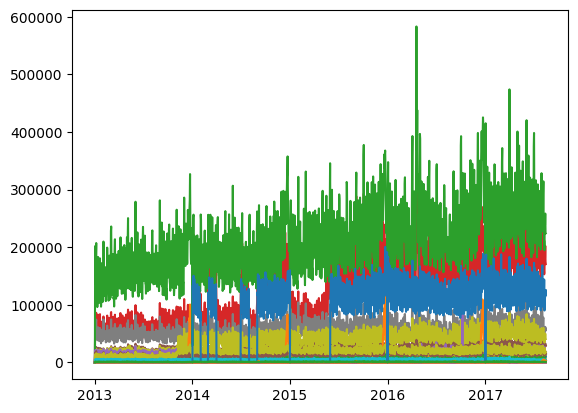

In [14]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])

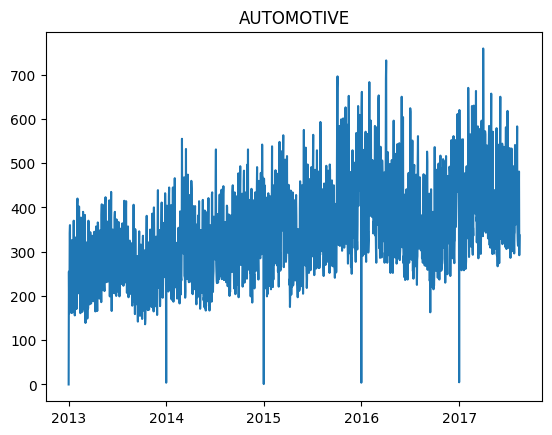

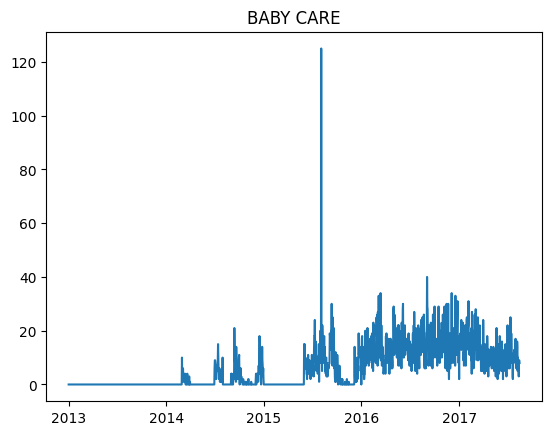

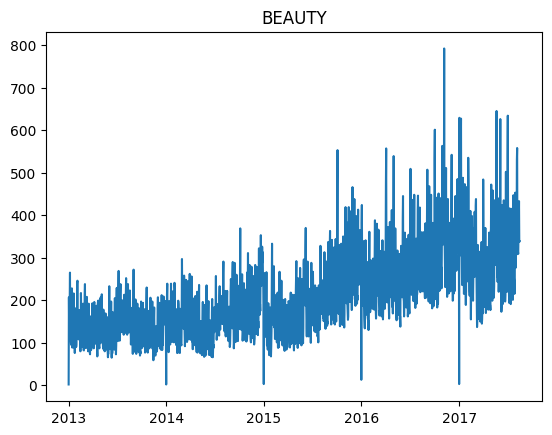

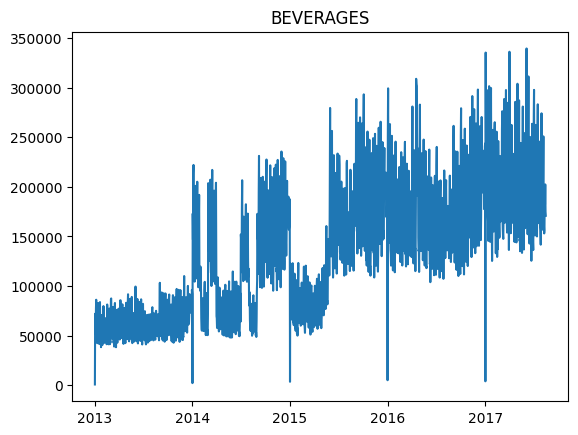

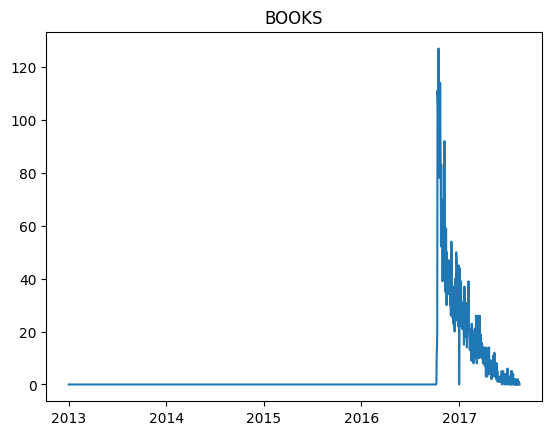

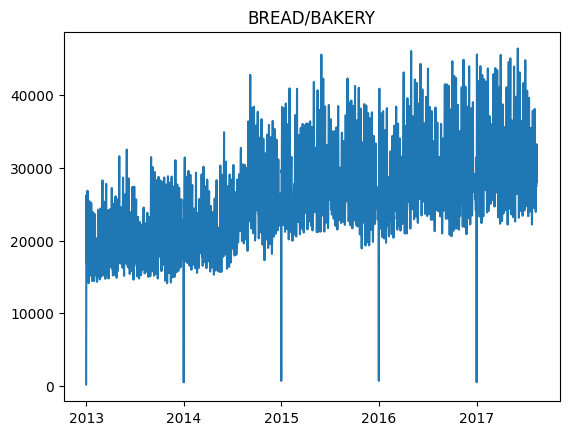

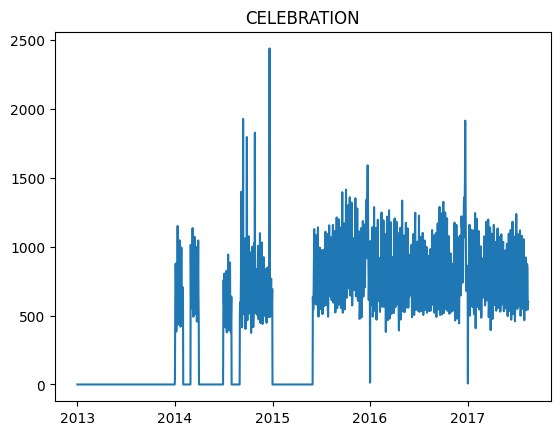

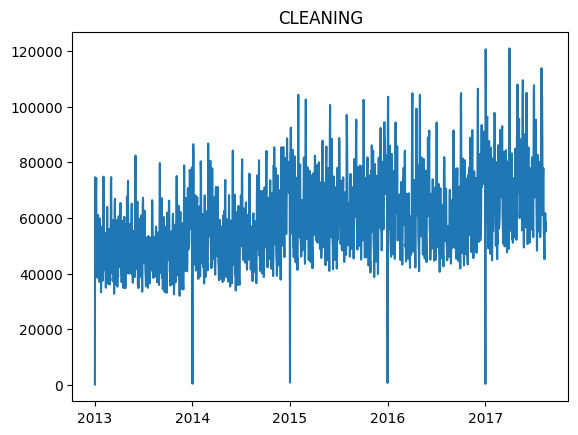

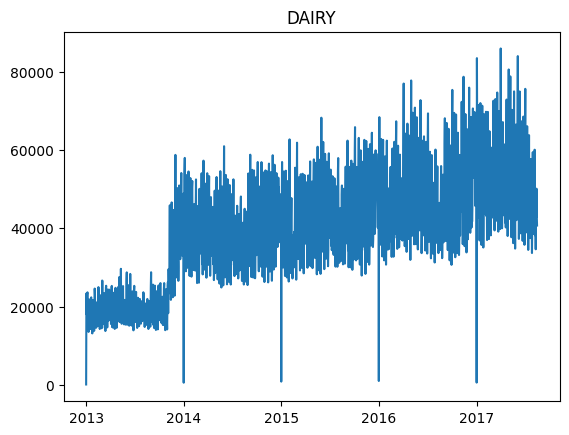

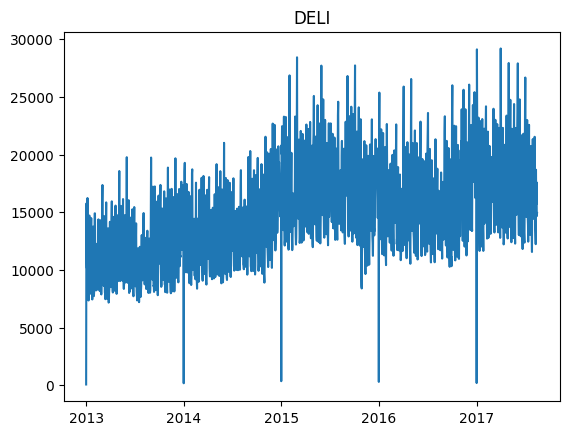

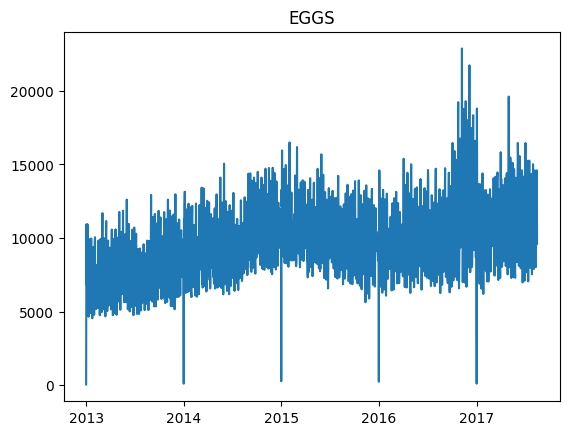

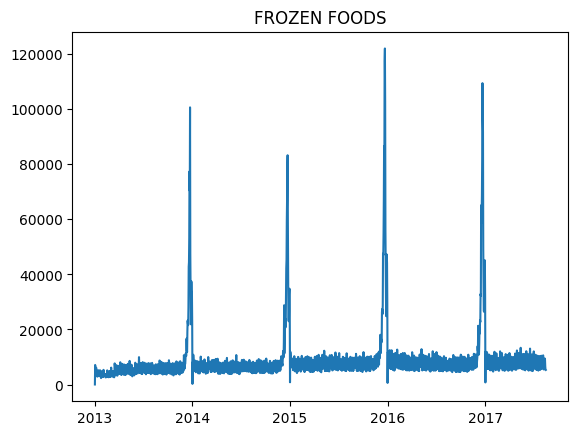

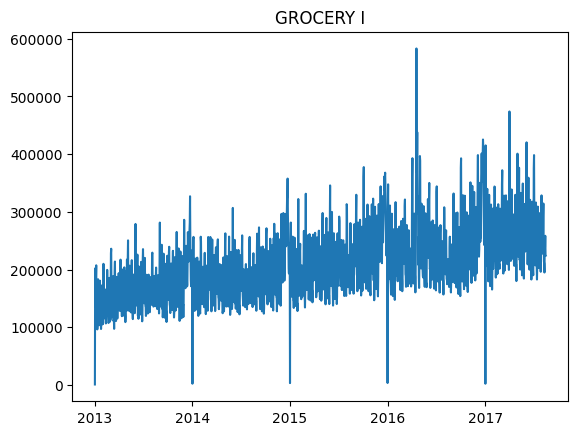

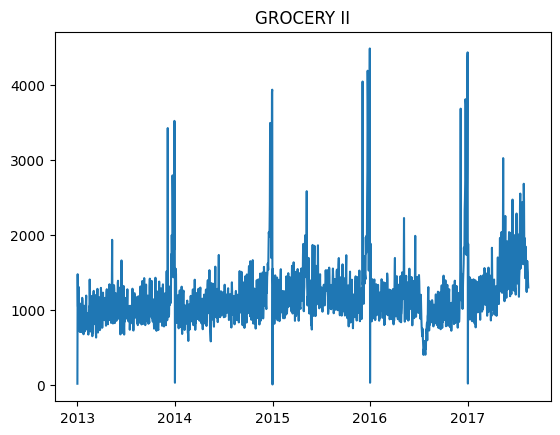

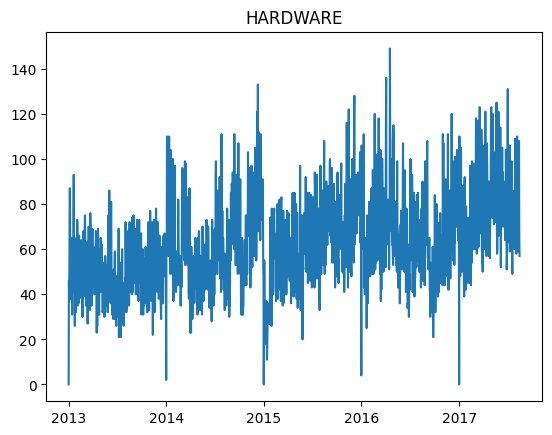

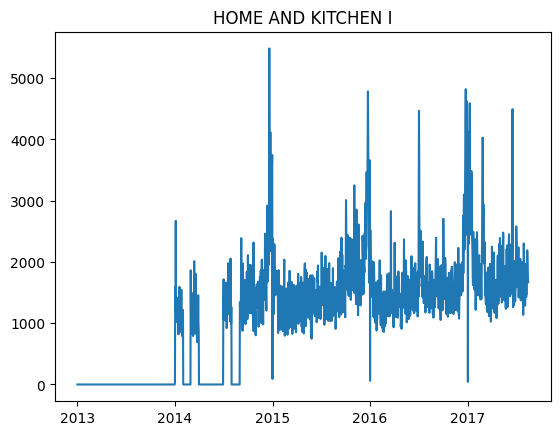

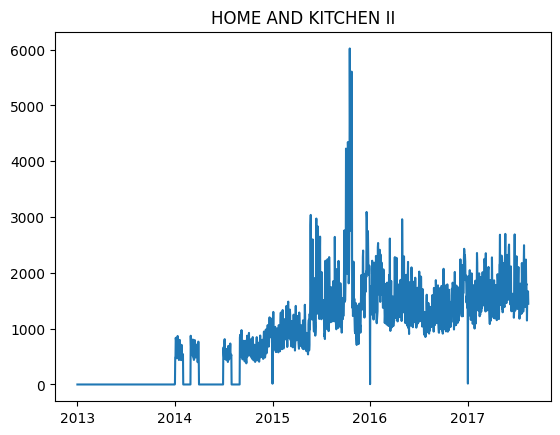

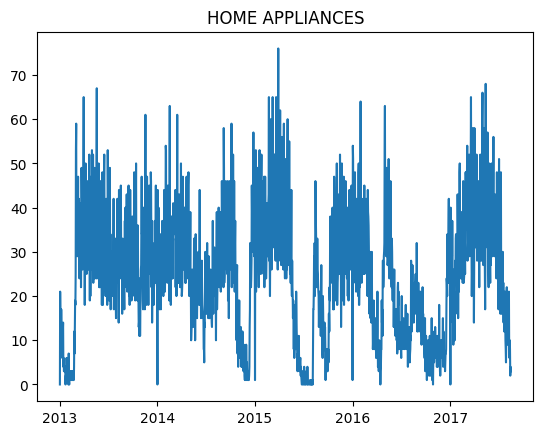

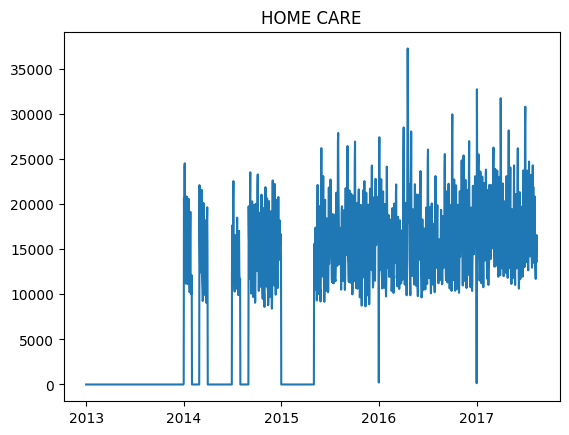

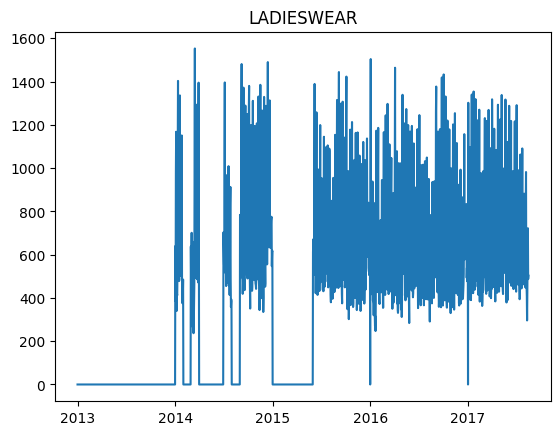

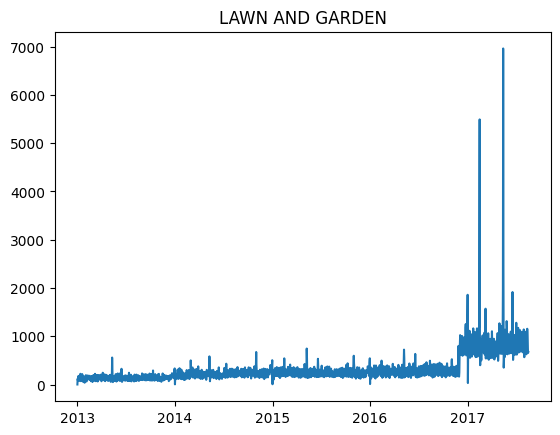

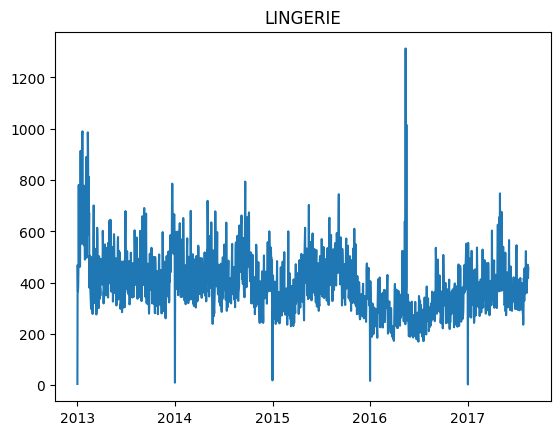

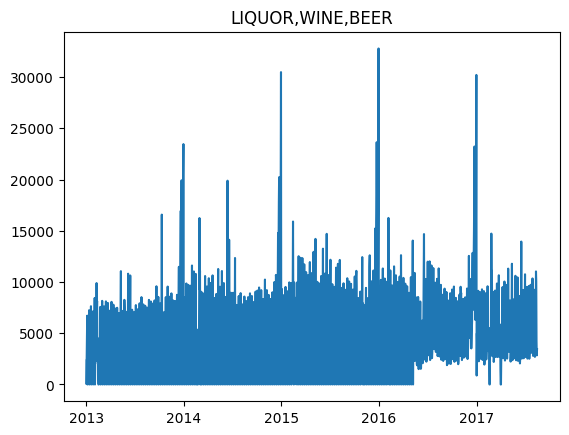

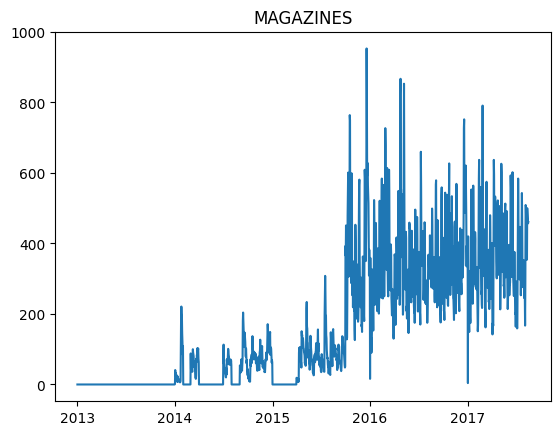

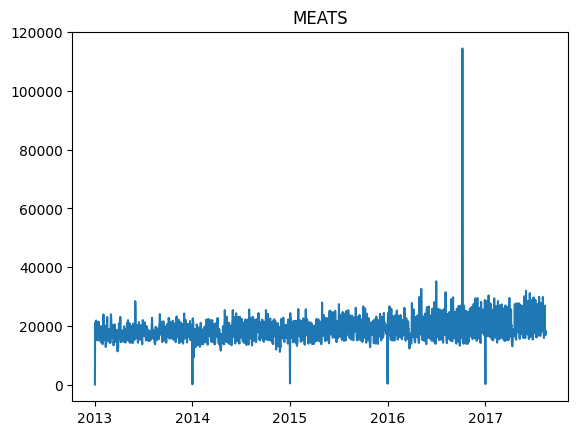

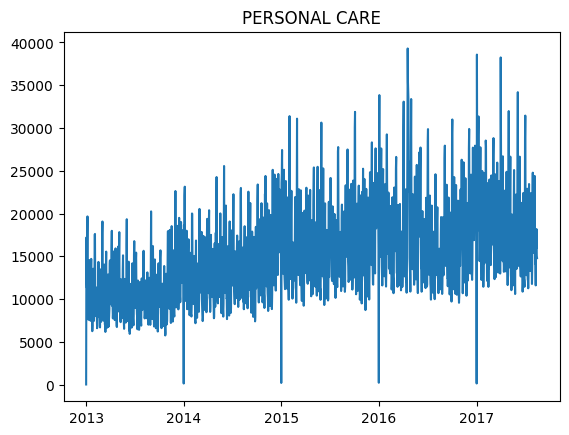

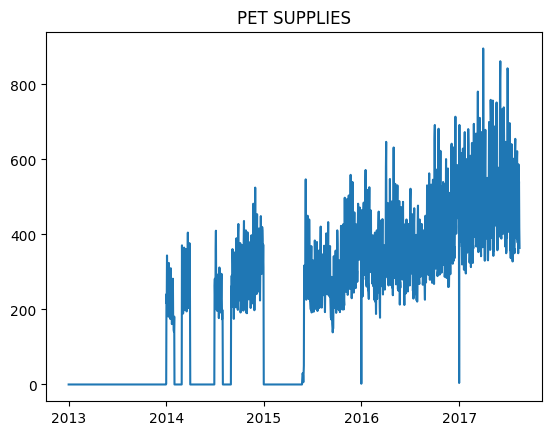

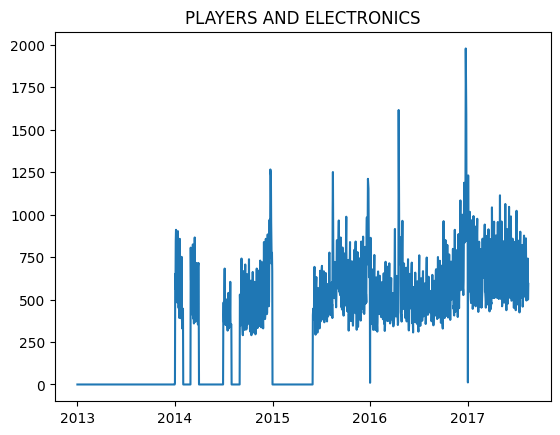

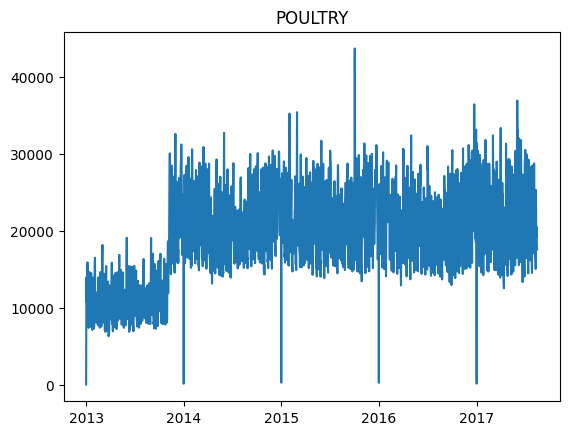

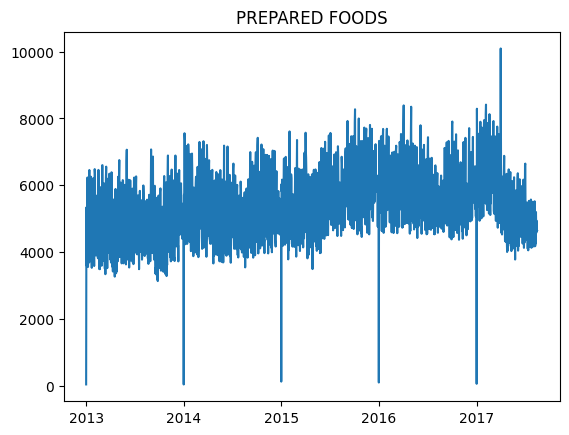

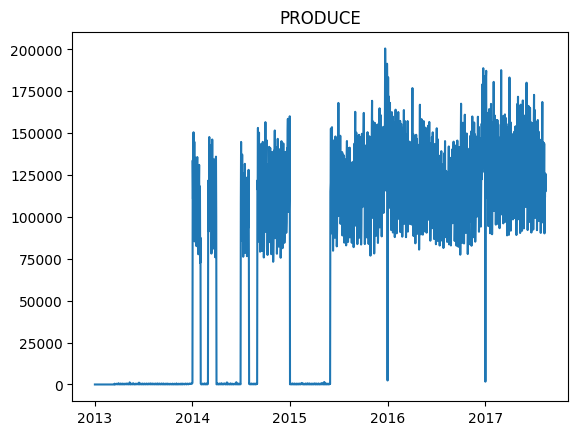

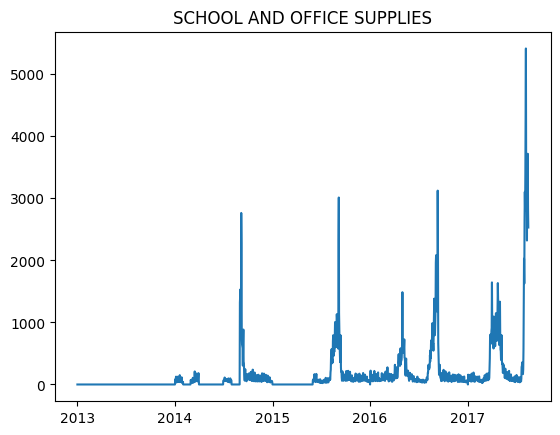

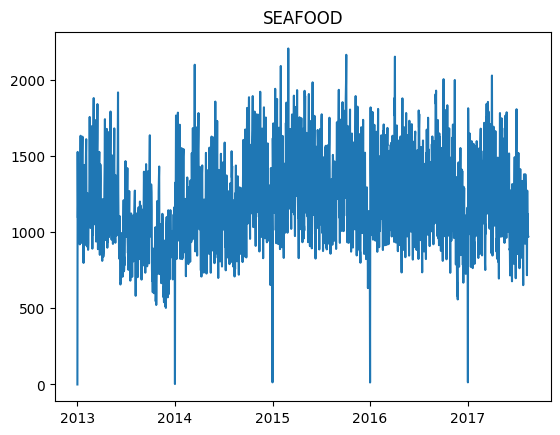

In [15]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

From the graphs it can be seen that the data is consistent from only 2015 for all the categories. Hecne for training and evaluation we consider data from 2015

In [16]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [17]:
missing_data(total_sales_df)

Total  Percent    Types
family                                             
AUTOMOTIVE                      0     0.00  float64
BABY CARE                       0     0.00  float64
BEAUTY                          0     0.00  float64
BEVERAGES                       0     0.00  float64
BOOKS                           0     0.00  float64
BREAD/BAKERY                    0     0.00  float64
CELEBRATION                     0     0.00  float64
CLEANING                        0     0.00  float64
DAIRY                           0     0.00  float64
DELI                            0     0.00  float64
EGGS                            0     0.00  float64
FROZEN FOODS                    0     0.00  float64
GROCERY I                       0     0.00  float64
GROCERY II                      0     0.00  float64
HARDWARE                        0     0.00  float64
HOME AND KITCHEN I              0     0.00  float64
HOME AND KITCHEN II             0     0.00  float64
HOME APPLIANCES                 0     0.00  float64
HOME CARE                       0     0.00  float64
LADIESWEAR                      0     0.00  float64
LAWN AND GARDEN                 0     0.00  float64
LINGERIE                        0     0.00  float64
LIQUOR,WINE,BEER                0     0.00  float64
MAGAZINES                       0     0.00  float64
MEATS                           0     0.00  float64
PERSONAL CARE                   0     0.00  float64
PET SUPPLIES                    0     0.00  float64
PLAYERS AND ELECTRONICS         0     0.00  float64
POULTRY                         0     0.00  float64
PREPARED FOODS                  0     0.00  float64
PRODUCE                         0     0.00  float64
SCHOOL AND OFFICE SUPPLIES      0     0.00  float64
SEAFOOD                         0     0.00  float64

Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

#### Category Grouping

In [18]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(avg_daily_sales,[33,66])
avg_daily_sales

family
BOOKS                             8.82
BABY CARE                        11.83
HOME APPLIANCES                  23.21
HARDWARE                         70.21
BEAUTY                          273.44
SCHOOL AND OFFICE SUPPLIES      315.06
MAGAZINES                       328.69
LINGERIE                        343.78
PET SUPPLIES                    381.50
AUTOMOTIVE                      383.20
LAWN AND GARDEN                 491.47
PLAYERS AND ELECTRONICS         576.36
LADIESWEAR                      626.31
CELEBRATION                     770.87
SEAFOOD                        1241.14
GROCERY II                     1246.87
HOME AND KITCHEN II            1560.60
HOME AND KITCHEN I             1707.09
LIQUOR,WINE,BEER               5157.08
PREPARED FOODS                 5643.84
FROZEN FOODS                   9828.31
EGGS                          10069.28
HOME CARE                     15734.36
DELI                          16222.12
PERSONAL CARE                 17091.29
MEATS             

In [19]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = list(avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index)
high_vol_columns = list(avg_daily_sales[avg_daily_sales>=mid].index)

In [20]:
low_vol_columns

['BOOKS',
 'BABY CARE',
 'HOME APPLIANCES',
 'HARDWARE',
 'BEAUTY',
 'SCHOOL AND OFFICE SUPPLIES',
 'MAGAZINES',
 'LINGERIE',
 'PET SUPPLIES',
 'AUTOMOTIVE',
 'LAWN AND GARDEN']

<Axes: xlabel='date'>

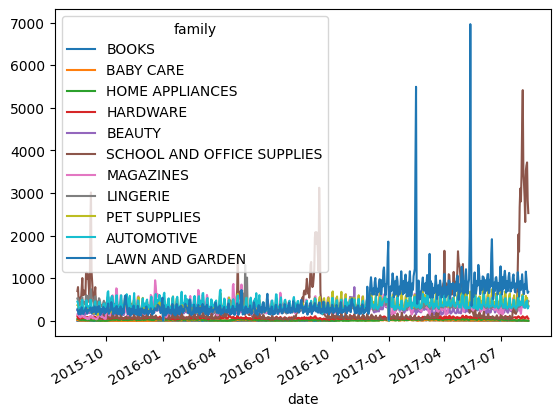

In [21]:
total_sales_df[low_vol_columns].plot.line()

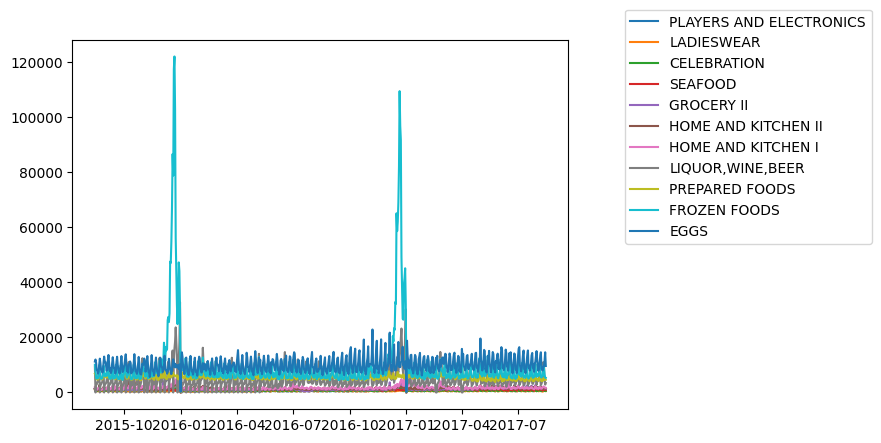

In [22]:
#OR
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.show()

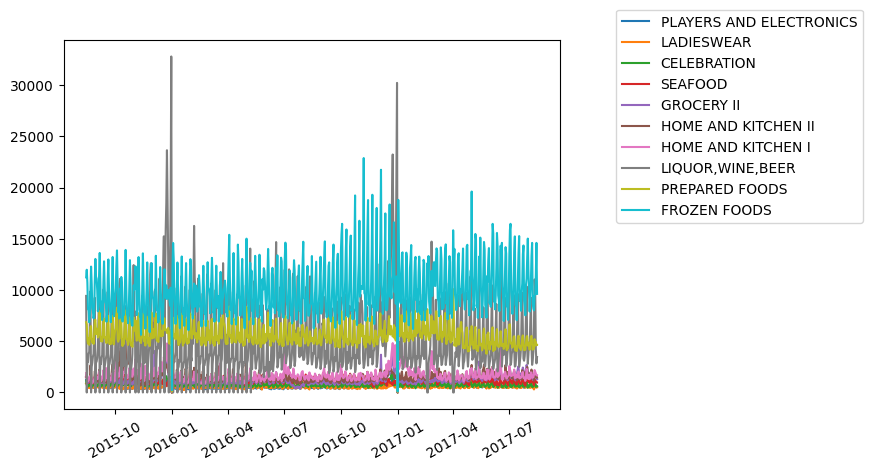

In [23]:
#OR
plt.plot(total_sales_df[mid_vol_columns].drop(columns = 'FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation = 30)
plt.show()

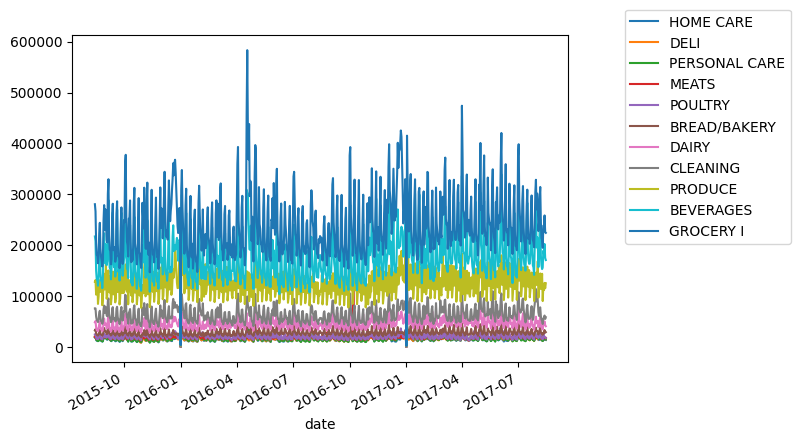

In [24]:
total_sales_df[high_vol_columns].plot.line()
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))

Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE."

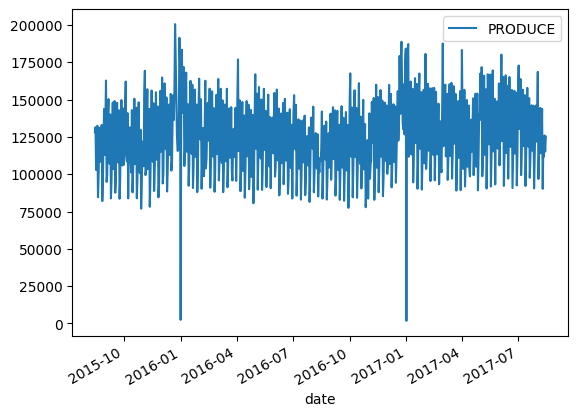

In [25]:
total_sales_df['PRODUCE'].plot.line()
plt.legend()

In [26]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [27]:
df1 = total_sales_df[[feature]].reset_index()
df1.head()

family       date   PRODUCE
0      2015-08-15 128147.18
1      2015-08-16 131493.93
2      2015-08-17 102769.60
3      2015-08-18 106468.23
4      2015-08-19 132449.58

In [28]:
df1.columns

Index(['date', 'PRODUCE'], dtype='object', name='family')

In [29]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

C:\Users\saras\AppData\Local\Temp\ipykernel_17300\1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

Holiday data is included so that abnormal patterns occuring in the data could be attributed to seasonality. this is bcoz holidays could induce seasonality ij purchase pattern. 

In [30]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15) so we take 45 days prior data to backtest
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") #convert datetime object to string format
print(forecast_start_date,type(forecast_start_date))
print(forecast_start_dt,type(forecast_start_dt))


2017-07-01 <class 'str'>
2017-07-01 <class 'datetime.date'>


#### Creating Model

In [31]:
#PROPHET MODEL

df_copy = df1.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

In [32]:
train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

11:23:34 - cmdstanpy - INFO - Chain [1] start processing
11:23:34 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
fcst_prophet_train.head(2)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-08-15 117881.11   110033.56   148372.08    117881.11    117881.11   
1 2015-08-16 117932.48   122134.48   160394.01    117932.48    117932.48   

   additive_terms  additive_terms_lower  additive_terms_upper   weekly  \
0        12018.93              12018.93              12018.93 12018.93   
1        22705.85              22705.85              22705.85 22705.85   

   weekly_lower  weekly_upper  multiplicative_terms  \
0      12018.93      12018.93                  0.00   
1      22705.85      22705.85                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                        0.00                        0.00 129900.04  
1                        0.00                        0.00 140638.32

In [34]:
fcst_prophet_train.tail(2)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
712 2017-07-29 133615.71   126479.00   164383.16    133419.22    133800.76   
713 2017-07-30 133652.00   137955.94   174037.74    133453.50    133852.31   

     additive_terms  additive_terms_lower  additive_terms_upper   weekly  \
712        12018.93              12018.93              12018.93 12018.93   
713        22705.85              22705.85              22705.85 22705.85   

     weekly_lower  weekly_upper  multiplicative_terms  \
712      12018.93      12018.93                  0.00   
713      22705.85      22705.85                  0.00   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
712                        0.00                        0.00 145634.63  
713                        0.00                        0.00 156357.84

In [35]:
#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]
predicted_df.head()

ds      yhat
684 2017-07-01 144618.47
685 2017-07-02 155341.69
686 2017-07-03 122390.83
687 2017-07-04 127649.41
688 2017-07-05 160258.38

In [36]:
df_copy.columns = ['ds','ytrue']
predicted_df = predicted_df.merge(df_copy)
predicted_df.head()

ds      yhat     ytrue
0 2017-07-01 144618.47 155487.63
1 2017-07-02 155341.69 172890.14
2 2017-07-03 122390.83 130389.20
3 2017-07-04 127649.41 131534.55
4 2017-07-05 160258.38 163804.33

In [37]:
MAPE = mape(predicted_df['ytrue'], predicted_df['yhat'])
MAPE

6.2695463285966

In [38]:
accuracy_score = 100-MAPE
accuracy_score

93.7304536714034

#### Cross Validation with Prophet
Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [39]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

11:23:35 - cmdstanpy - INFO - Chain [1] start processing
11:23:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]11:23:35 - cmdstanpy - INFO - Chain [1] start processing


11:23:35 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  5.41it/s]11:23:35 - cmdstanpy - INFO - Chain [1] start processing
11:23:35 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  5.66it/s]11:23:35 - cmdstanpy - INFO - Chain [1] start processing
11:23:35 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  5.79it/s]11:23:36 - cmdstanpy - INFO - Chain [1] start processing
11:23:36 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:01,  5.69it/s]11:23:36 - cmdstanpy - INFO - Chain [1] start processing
11:23:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  5.57it/s]11:23:36 - cmdstanpy - INFO - Chain [1] start processing
11:23:36 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:01<00:00,  5.55it/s]11:23:36 - cmdstanpy - INFO - Chain [1] start processing
11:23:36 - cmdstanpy - INFO - Chain [1] done p

Initial means the data that we are giving the model for training. In this case it would be from 8-15-2015 to 8-15-2016.
Period is the time interval between cutoff points. Horizon is the time period for which we do the prediction

So in CV we do the prediction for 30 days in an interval of 30 days and compare it with the actual data available to calculate the MAPE score.

In [40]:
df_cv.head()

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2016-09-04 137039.27   119698.63   154152.82 144954.39 2016-09-03
1 2016-09-05 103690.38    84875.34   120794.69 110104.68 2016-09-03
2 2016-09-06 107783.52    91901.10   124540.45 115898.16 2016-09-03
3 2016-09-07 140063.59   123723.23   157088.72 142809.15 2016-09-03
4 2016-09-08  84274.68    67621.18   100984.51  85680.68 2016-09-03

In [41]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  3 days 413361172.92 20331.29 13110.68  0.09   0.07   0.10      0.77
1  4 days 270356083.07 16442.51 11138.40  0.08   0.06   0.08      0.80
2  5 days 141922529.27 11913.12  8919.14  0.07   0.06   0.07      0.87
3  6 days 126636792.69 11253.30  9242.82  0.07   0.07   0.07      0.87
4  7 days  96397132.07  9818.20  8434.36  0.07   0.07   0.07      0.93

In [42]:
df_p = performance_metrics(df_cv)
df_p.tail()

horizon           mse     rmse      mae  mape  mdape  smape  coverage
23 26 days  254209603.50 15943.95 11982.65  0.10   0.08   0.10      0.83
24 27 days  304749478.17 17457.08 13222.78  0.11   0.09   0.11      0.80
25 28 days  501859646.62 22402.22 15697.81  0.13   0.09   0.13      0.77
26 29 days  549449887.15 23440.35 16626.19  0.12   0.09   0.13      0.66
27 30 days 1247603990.53 35321.44 21539.76  3.01   0.12   0.19      0.63

df_p gives the overall MAPE, but if one wants to get more granular and calculate the daily differences using the mape metric, the code is below. This allows one to detect issues in predicting certain time periods, which are inherent issues in the data that may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [43]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

ds      yhat  yhat_lower  yhat_upper         y     cutoff  mape  \
110 2016-12-23  98436.01    82230.51   114336.89 176327.97 2016-12-02 44.17   
116 2016-12-30  98482.27    82516.94   115031.33 175022.19 2016-12-02 43.73   
109 2016-12-22  87948.81    72534.66   104701.56 140444.94 2016-12-02 37.38   
119 2017-01-02 116970.37    96490.77   135149.72 184113.03 2017-01-01 36.47   
120 2017-01-03 121230.03   102320.86   140610.97 183306.23 2017-01-01 33.86   
111 2016-12-24 127835.66   111567.12   142757.86 188809.16 2016-12-02 32.29   
117 2016-12-31 127881.92   112347.48   143511.35 184154.67 2016-12-02 30.56   
115 2016-12-29  87995.07    72675.67   104294.01 126652.84 2016-12-02 30.52   
238 2017-05-01 126221.70   105367.58   145383.76 167558.58 2017-04-01 24.67   
108 2016-12-21 143739.73   128556.29   159096.35 179251.71 2016-12-02 19.81   

     overestimate  
110         False  
116         False  
109         False  
119         False  
120         False  
111         False  
117         False  
115         False  
238         False  
108         False

If you check the dates, it can be seen that the error values occur mostly in december. Its a good idea to check the plot of produce 

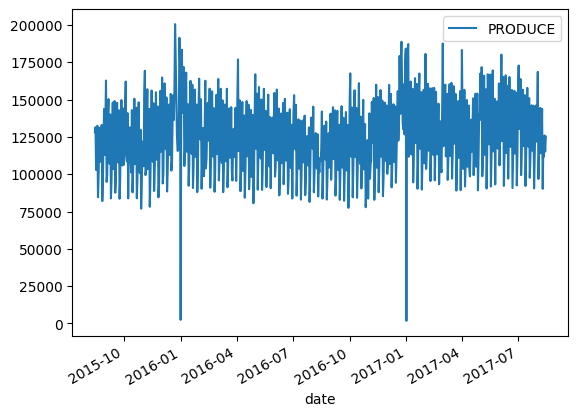

In [44]:
total_sales_df['PRODUCE'].plot.line()
plt.legend()

The high MAPE during december is due to the unexpected spike in the original data (could be a systematic error). we have to remove that data as it will affect the time series prediction

#### Hypertuning the model

In [45]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

11:23:37 - cmdstanpy - INFO - Chain [1] start processing
11:23:38 - cmdstanpy - INFO - Chain [1] done processing
11:23:42 - cmdstanpy - INFO - Chain [1] start processing
11:23:42 - cmdstanpy - INFO - Chain [1] done processing
11:23:46 - cmdstanpy - INFO - Chain [1] start processing
11:23:46 - cmdstanpy - INFO - Chain [1] done processing
11:23:50 - cmdstanpy - INFO - Chain [1] start processing
11:23:50 - cmdstanpy - INFO - Chain [1] done processing
11:23:54 - cmdstanpy - INFO - Chain [1] start processing
11:23:55 - cmdstanpy - INFO - Chain [1] done processing
11:23:58 - cmdstanpy - INFO - Chain [1] start processing
11:23:58 - cmdstanpy - INFO - Chain [1] done processing
11:24:01 - cmdstanpy - INFO - Chain [1] start processing
11:24:01 - cmdstanpy - INFO - Chain [1] done processing
11:24:05 - cmdstanpy - INFO - Chain [1] start processing
11:24:05 - cmdstanpy - INFO - Chain [1] done processing
11:24:09 - cmdstanpy - INFO - Chain [1] start processing
11:24:09 - cmdstanpy - INFO - Chain [1]

In [46]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18576.72
3                      0.00                    10.00 18559.79
4                      0.01                     0.01 18219.08
5                      0.01                     0.10 17783.85
6                      0.01                     1.00 17762.83
7                      0.01                    10.00 17719.63
8                      0.10                     0.01 18055.73
9                      0.10                     0.10 17747.48
10                     0.10                     1.00 17724.97
11                     0.10                    10.00 17725.03
12                     0.50                     0.01 18085.32
13                     0.50                     0.10 17735.37
14                     0.50                     1.00 17757.46
15      

In [47]:
tuning_results.sort_values('rmse').head(3)

changepoint_prior_scale  seasonality_prior_scale     rmse
7                      0.01                    10.00 17719.63
10                     0.10                     1.00 17724.97
11                     0.10                    10.00 17725.03

In [48]:
tuning_results.sort_values('rmse').reset_index(drop=True).head(3)

changepoint_prior_scale  seasonality_prior_scale     rmse
0                     0.01                    10.00 17719.63
1                     0.10                     1.00 17724.97
2                     0.10                    10.00 17725.03

In [49]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 10.0,
 'rmse': 17719.62832124312}

In [50]:
params_dict = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis =1).iloc[0])
params_dict

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}

In [51]:
m = Prophet(changepoint_prior_scale = params_dict['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dict['seasonality_prior_scale'])

In [52]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

#df_copy = df.copy()
#df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

11:24:39 - cmdstanpy - INFO - Chain [1] start processing
11:24:39 - cmdstanpy - INFO - Chain [1] done processing


4.837441712614779

After hyperparameter tuning, the MAPE reduced to 4.8 from 6.2

Now we need to build a pipeline for all the columns. So far we have just tried only one column 'PRODUCE'. So start by cleaning all the columns  

#### DATA CLEANING REQUIREMENTS
1. Remove low-volume data that can't be predicted.Otherwise there will be a lot of noise in the data
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.)
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.If trend remains same for more than 2 years its better to take those years as well into account. 

##### Removing columns with insufficient data

In [53]:
total_sales_df.head(3)

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2015-08-15      454.00      18.00  251.00  217135.00   0.00      32509.91   
2015-08-16      413.00      11.00  313.00  208213.00   0.00      34851.88   
2015-08-17      289.00      14.00  175.00  149741.00   0.00      26361.77   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2015-08-15      1157.00  75837.00 48578.00 19946.92 11232.00      10075.02   
2015-08-16       724.00  75824.00 50930.00 21178.46 11977.00       7526.03   
2015-08-17       593.00  59718.00 38358.00 15755.02 10713.00       5145.30   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2015-08-15  280491.48     1552.00    108.00             1899.00   
2015-08-16  266657.28     1441.00     62.00             1418.00   
2015-08-17  205150.61     1161.00     49.00             1143.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2015-08-15              1526.00            46.00   18924.00      879.00   
2015-08-16              1850.00            45.00   19757.00      955.00   
2015-08-17              1343.00            36.00   14120.00      564.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2015-08-15           268.00    525.00           9423.00     153.00 20403.94   
2015-08-16           220.00    530.00              0.00     157.00 20616.16   
2015-08-17           154.00    480.00           2968.00     125.00 16725.03   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2015-08-15       19398.00        370.00                  1250.00 24718.80   
2015-08-16       21048.00        359.00                   913.00 25480.78   
2015-08-17       14854.00        263.00                   593.00 18549.11   

family      PREPARED FOODS   PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                       
2015-08-15         6854.54 128147.18                      701.00  1507.24  
2015-08-16         6640.39 131493.93                      793.00  1448.72  
2015-08-17         5212.50 102769.60                      458.00  1166.22

In [54]:
total_sales_df.apply(np.mean,axis=0)>1000

family
AUTOMOTIVE                    False
BABY CARE                     False
BEAUTY                        False
BEVERAGES                      True
BOOKS                         False
BREAD/BAKERY                   True
CELEBRATION                   False
CLEANING                       True
DAIRY                          True
DELI                           True
EGGS                           True
FROZEN FOODS                   True
GROCERY I                      True
GROCERY II                     True
HARDWARE                      False
HOME AND KITCHEN I             True
HOME AND KITCHEN II            True
HOME APPLIANCES               False
HOME CARE                      True
LADIESWEAR                    False
LAWN AND GARDEN               False
LINGERIE                      False
LIQUOR,WINE,BEER               True
MAGAZINES                     False
MEATS                          True
PERSONAL CARE                  True
PET SUPPLIES                  False
PLAYERS AND ELECTRONI

In [55]:
total_sales_df.columns[total_sales_df.apply(np.mean,axis=0)>1000]

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'LIQUOR,WINE,BEER', 'MEATS',
       'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')

In [56]:
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis=0)>1000]]
total_sales_df.head(3)

family      BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY     DELI     EGGS  \
date                                                                       
2015-08-15  217135.00      32509.91  75837.00 48578.00 19946.92 11232.00   
2015-08-16  208213.00      34851.88  75824.00 50930.00 21178.46 11977.00   
2015-08-17  149741.00      26361.77  59718.00 38358.00 15755.02 10713.00   

family      FROZEN FOODS  GROCERY I  GROCERY II  HOME AND KITCHEN I  \
date                                                                  
2015-08-15      10075.02  280491.48     1552.00             1899.00   
2015-08-16       7526.03  266657.28     1441.00             1418.00   
2015-08-17       5145.30  205150.61     1161.00             1143.00   

family      HOME AND KITCHEN II  HOME CARE  LIQUOR,WINE,BEER    MEATS  \
date                                                                    
2015-08-15              1526.00   18924.00           9423.00 20403.94   
2015-08-16              1850.00   19757.00              0.00 20616.16   
2015-08-17              1343.00   14120.00           2968.00 16725.03   

family      PERSONAL CARE  POULTRY  PREPARED FOODS   PRODUCE  SEAFOOD  
date                                                                   
2015-08-15       19398.00 24718.80         6854.54 128147.18  1507.24  
2015-08-16       21048.00 25480.78         6640.39 131493.93  1448.72  
2015-08-17       14854.00 18549.11         5212.50 102769.60  1166.22

In [57]:
total_sales_df.shape

(730, 19)

Dropped 14 columns due to insufficient data volume

##### Removing columns with many zeros

In [69]:
zero_col = total_sales_df.eq(0).sum()
zero_col

family
BEVERAGES               0
BREAD/BAKERY            0
CLEANING                0
DAIRY                   0
DELI                    0
EGGS                    0
FROZEN FOODS            0
GROCERY I               0
GROCERY II              0
HOME AND KITCHEN I      0
HOME AND KITCHEN II     0
HOME CARE               0
LIQUOR,WINE,BEER       42
MEATS                   0
PERSONAL CARE           0
POULTRY                 0
PREPARED FOODS          0
PRODUCE                 0
SEAFOOD                 0
dtype: int64

In [71]:
proportion_zero = zero_col/len(total_sales_df)
proportion_zero

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
LIQUOR,WINE,BEER      0.06
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

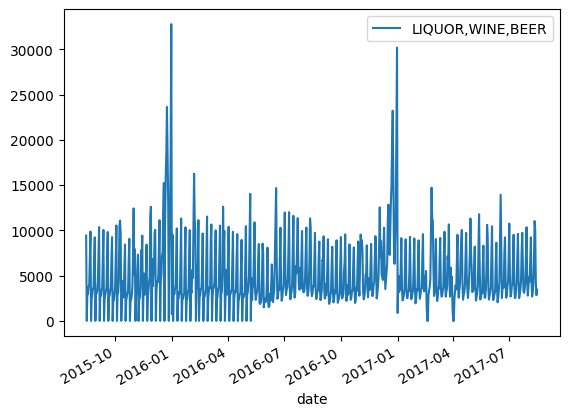

In [73]:
total_sales_df['LIQUOR,WINE,BEER'].plot.line()
plt.legend()

In [76]:
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)

In [78]:
total_sales_df.columns

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')

##### Outlier removal

In [114]:
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()

In [115]:
df_clean.head()

family       date  SEAFOOD
0      2015-08-15  1507.24
1      2015-08-16  1448.72
2      2015-08-17  1166.22
3      2015-08-18   951.63
4      2015-08-19   996.73

In [116]:
from scipy.stats import zscore
z = np.abs(zscore(df_clean[column]))
outlier_index = np.where(z>2.7)[0]
outlier_index

array([ 50, 138, 231, 503], dtype=int64)

In [117]:
df_clean.drop(index = outlier_index,inplace = True)
df_clean.set_index('date', inplace=True)
df_clean.head(3)

family      SEAFOOD
date               
2015-08-15  1507.24
2015-08-16  1448.72
2015-08-17  1166.22

In [118]:
#putting it in a loop for all the columns
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


In [134]:
prediction_df_list,len(prediction_df_list),type(prediction_df_list)


([family      BEVERAGES
  date                 
  2015-08-15  217135.00
  2015-08-16  208213.00
  2015-08-17  149741.00
  2015-08-18  132609.00
  2015-08-19  131368.00
  2015-08-20  120312.00
  2015-08-21  138317.00
  2015-08-22  177761.00
  2015-08-23  195491.00
  2015-08-24  144581.00
  2015-08-25  130586.00
  2015-08-26  130276.00
  2015-08-27  115548.00
  2015-08-28  138499.00
  2015-08-29  196492.00
  2015-08-30  223201.00
  2015-08-31  165371.00
  2015-09-01  201878.00
  2015-09-02  187208.00
  2015-09-03  160764.00
  2015-09-04  168572.00
  2015-09-05  254856.00
  2015-09-06  288474.00
  2015-09-07  184317.00
  2015-09-08  155460.00
  2015-09-09  154908.00
  2015-09-10  132801.00
  2015-09-11  152567.00
  2015-09-12  228446.00
  2015-09-13  264504.00
  2015-09-14  167985.00
  2015-09-15  157006.00
  2015-09-16  164646.00
  2015-09-17  138240.00
  2015-09-18  149665.00
  2015-09-19  226917.00
  2015-09-20  269952.00
  2015-09-21  171329.00
  2015-09-22  147748.00
  2015-09-23  15

In [129]:
prediction_df_list[0].columns[0]

'BEVERAGES'

In [142]:
int(prediction_df_list[0].mean().iloc[0])

177112

In [137]:
prediction_df_list[1].head()

family      BREAD/BAKERY
date                    
2015-08-15      32509.91
2015-08-16      34851.88
2015-08-17      26361.77
2015-08-18      23915.95
2015-08-19      23995.15

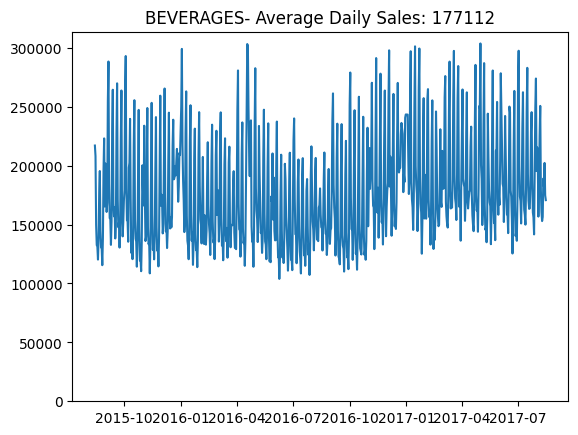

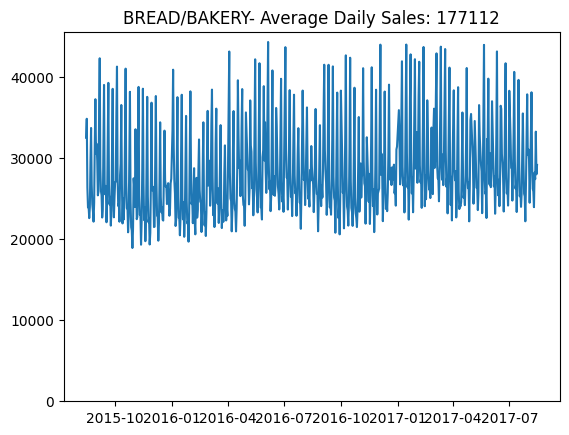

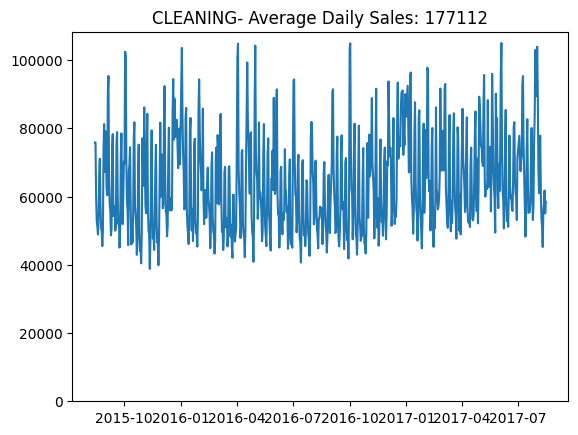

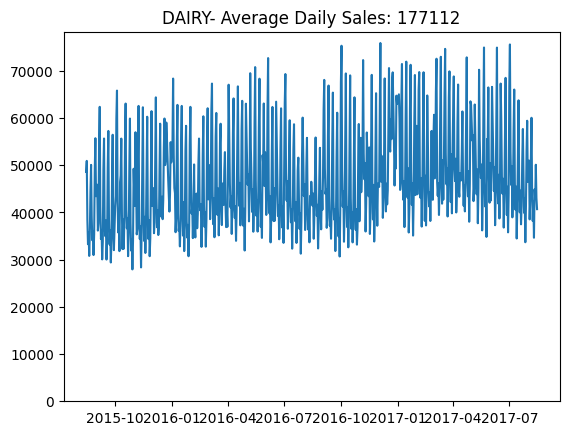

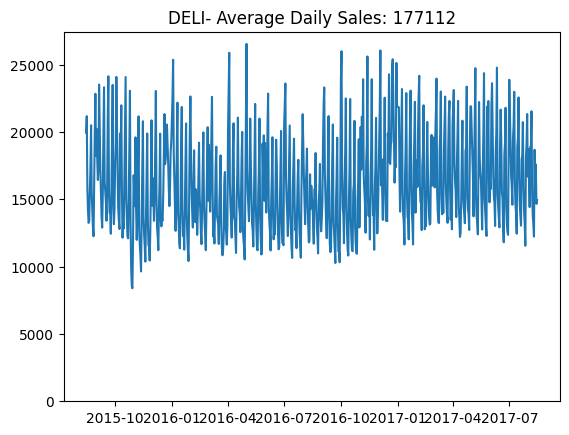

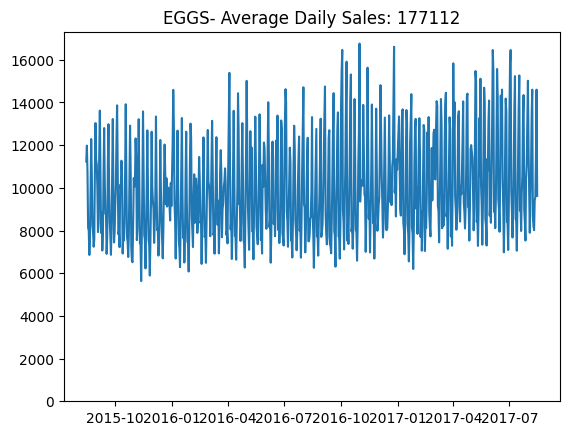

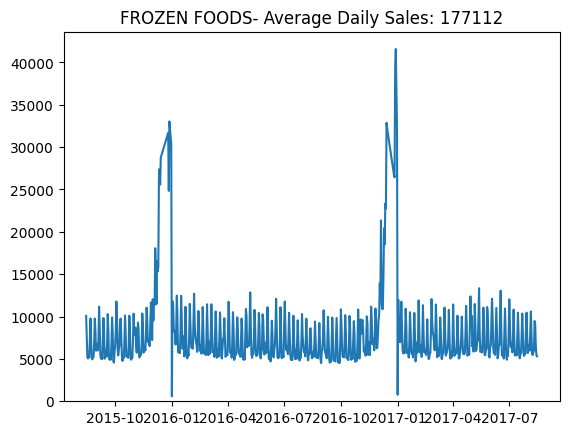

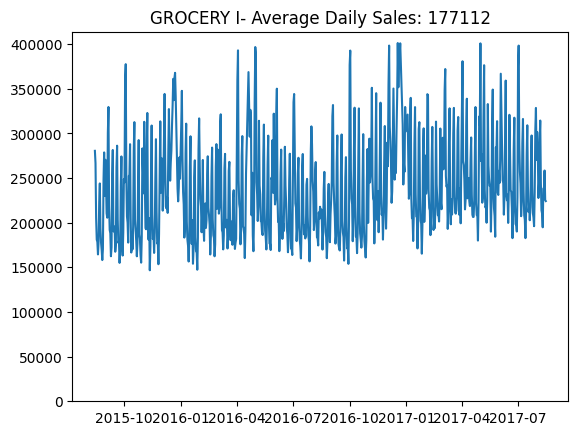

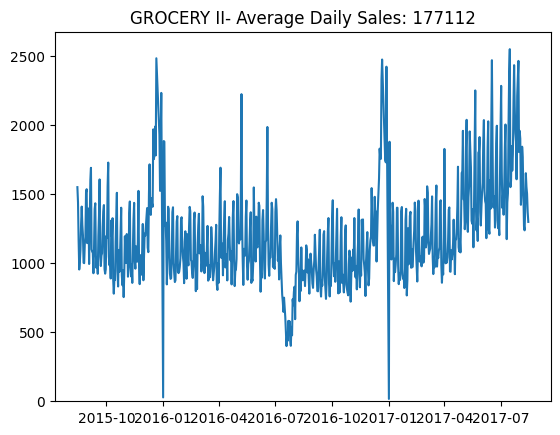

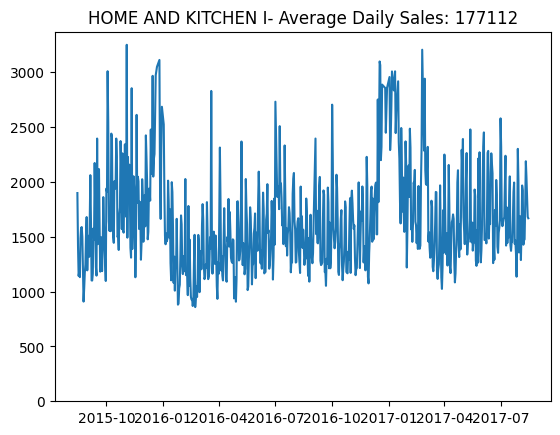

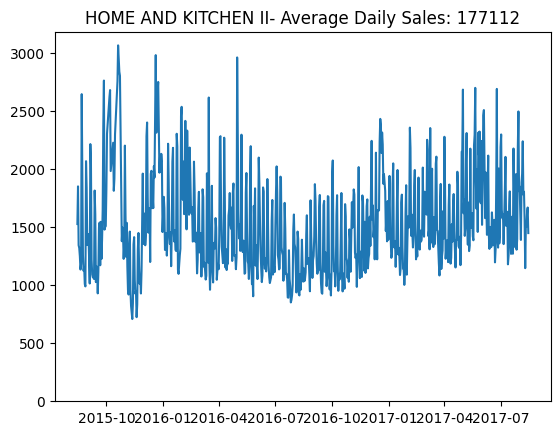

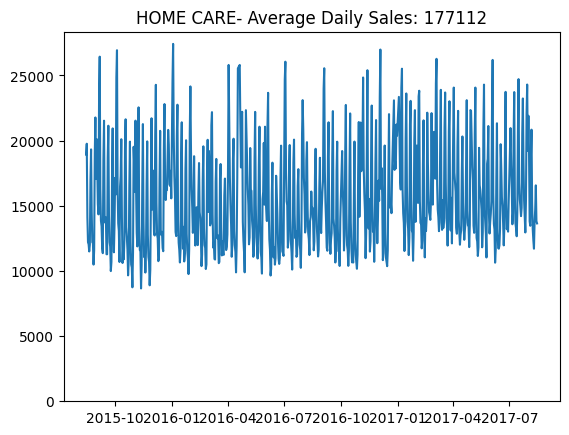

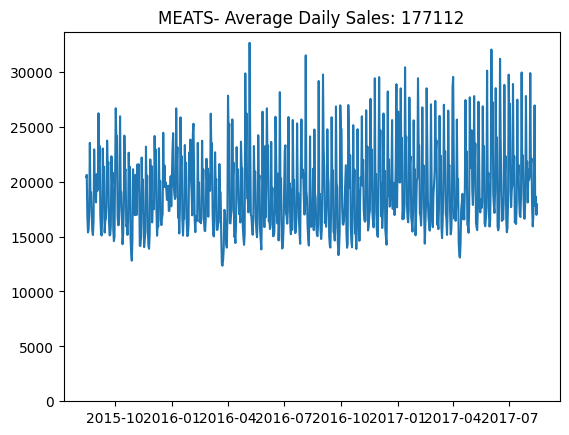

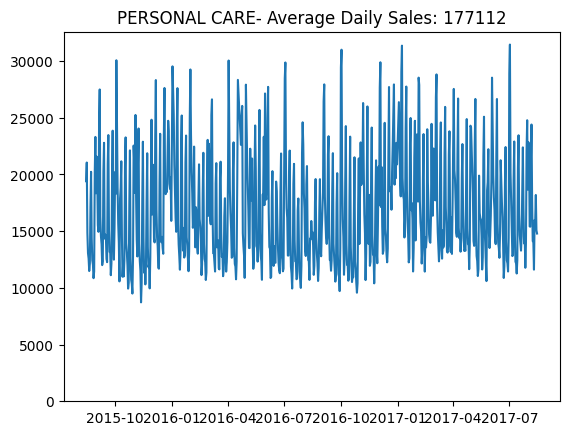

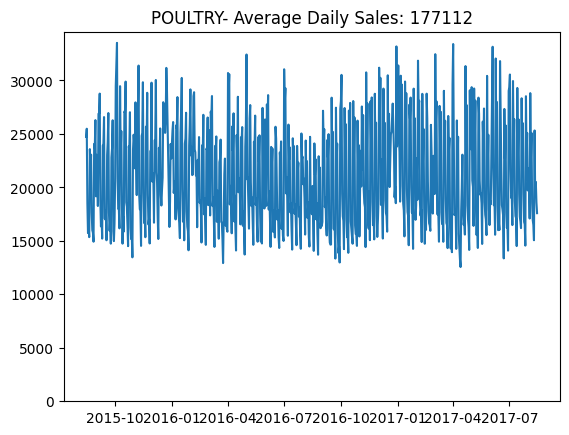

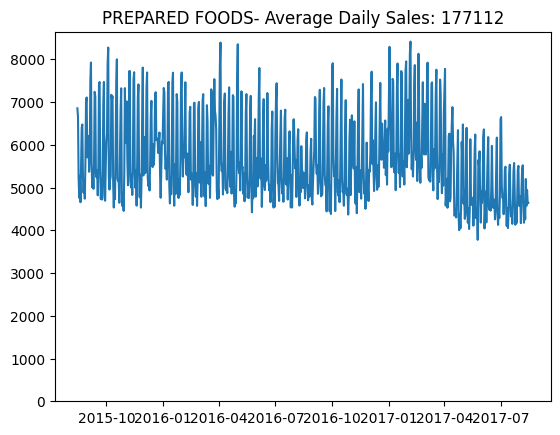

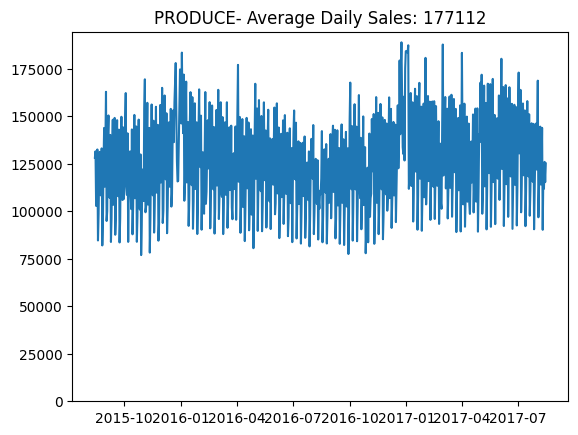

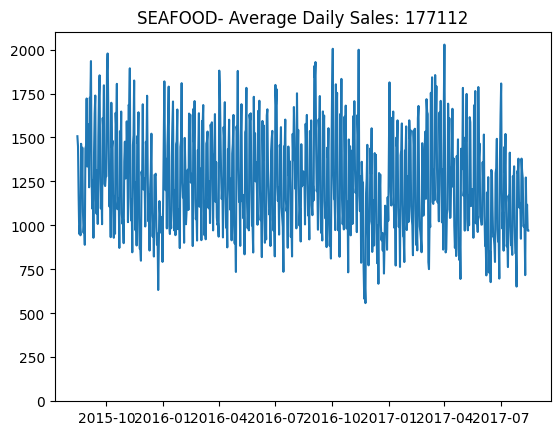

In [145]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(int(prediction_df_list[0].mean().iloc[0])))
    plt.ylim(ymin=0)
    plt.show()

#### PLOTTING CATEGORIES

In [146]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [147]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

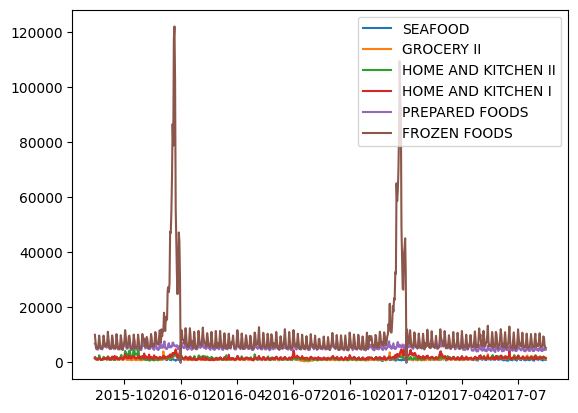

In [148]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

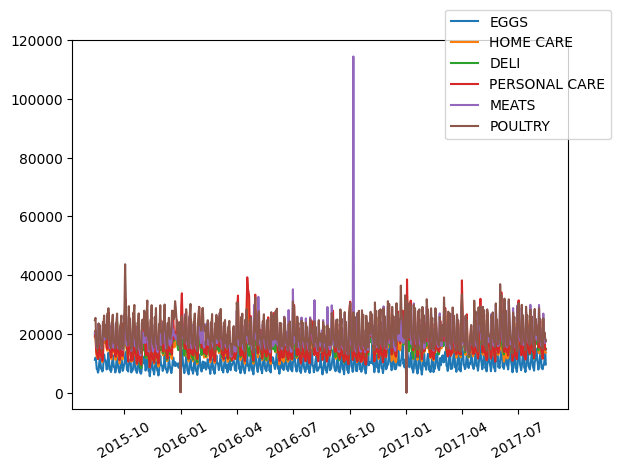

In [149]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

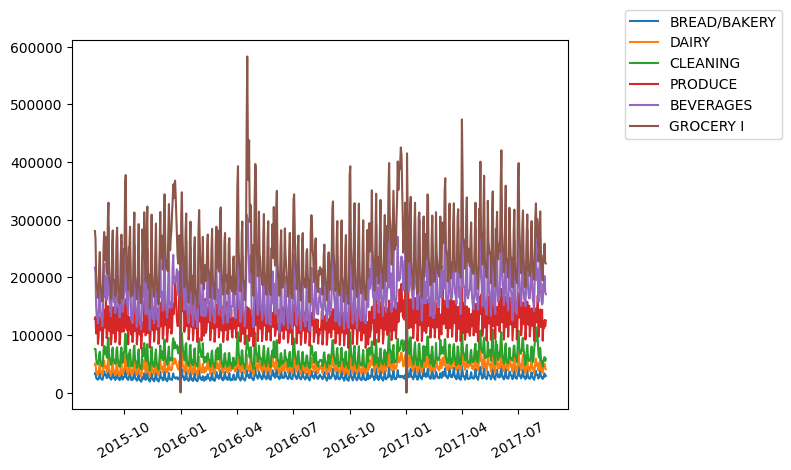

In [150]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

#### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [152]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [154]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [156]:
import time
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.47it/s]17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.48it/s]17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.07it/s

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2046068804.79 45233.49 34229.75  0.33   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:11,  1.03s/it]17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:05,  1.86it/s]17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.56it/s]17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.12it/s]17:59:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2184834031.78 46742.21 36720.37  0.37   0.17   0.22      0.53


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:11,  1.05s/it]17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:05,  1.82it/s]17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.50it/s]17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2167461343.34 46556.00 36444.87  0.37   0.17   0.22      0.57


  0%|          | 0/12 [00:00<?, ?it/s]17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:10,  1.08it/s]17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:04,  2.03it/s]17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.68it/s]17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.30it/s]17:59:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2156000724.35 46432.75 36236.30  0.36   0.17   0.22      0.57


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:10,  1.10it/s]17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:04,  2.07it/s]17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160631349.20 46482.59 36395.90  0.37   0.17   0.22      0.56


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.42it/s]17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.10it/s]17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.67it/s]17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1023401548.96 31990.65 22181.60  0.29   0.09   0.12      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.07it/s]17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.58it/s]17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.25it/s]17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.10it/s]17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1015866623.43 31872.66 21647.16  0.30   0.09   0.12      0.79


18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.10it/s]18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.90it/s]18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.95it/s]18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1008237187.50 31752.75 21523.89  0.30   0.09   0.12      0.79


18:00:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.26it/s]18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.44it/s]18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:04<00:15,  1.75s/it]18:00:07 - cmdstanpy - INFO - Chain [1] start processing

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1008887105.88 31762.98 21525.70  0.30   0.08   0.12      0.79


18:00:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.58it/s]18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.02it/s]18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:03<00:14,  1.62s/it]18:00:14 - cmdstanpy - INFO - Chain [1] start processing

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1018085297.01 31907.45 21694.35  0.30   0.09   0.12      0.79


18:00:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.04it/s]18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.22it/s]18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.46it/s]18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.20it/s]18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.16it/s]18:00:1

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1043127714.58 32297.49 22155.94  0.30   0.09   0.12      0.77


18:00:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.87it/s]18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.90it/s]18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.49it/s]18:00:20 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.50it/s]18:00:2

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1067013889.62 32665.18 22178.03  0.31   0.09   0.12      0.77


18:00:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.62it/s]18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.77it/s]18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.65it/s]18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.46it/s]18:00:2

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1068383424.62 32686.14 22215.48  0.31   0.09   0.12      0.77


18:00:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:26 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.89it/s]18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:26 - cmdstanpy - INFO - Chain [1] done processing
18:00:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:02<00:14,  1.49s/it]18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:02<00:08,  1.07it/s]18:00:29 - cmdstanpy - INFO - Chain [1] start processing

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1066996070.76 32664.91 22180.32  0.31   0.09   0.12      0.77


18:00:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.73it/s]18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.04it/s]18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.06it/s]18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  4.00it/s]18:00:33 - cmdstanpy - INFO - Chain [1] start processing
18:00:33 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.89it/s]18:00:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1072919284.82 32755.45 22247.38  0.31   0.09   0.12      0.76


18:00:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:35 - cmdstanpy - INFO - Chain [1] start processing
18:00:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.64it/s]18:00:35 - cmdstanpy - INFO - Chain [1] start processing
18:00:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.54it/s]18:00:35 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.13it/s]18:00:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1046558750.08 32350.56 22120.52  0.30   0.09   0.12      0.78


18:00:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.79it/s]18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.74it/s]18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.60it/s]18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.47it/s]18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.37it/s]18:00:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1108220665.96 33289.95 23002.05  0.31   0.10   0.13      0.75


18:00:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.38it/s]18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.31it/s]18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.05it/s]18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.93it/s]18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.93it/s]18:00:4

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1114001211.78 33376.66 23134.83  0.31   0.10   0.13      0.76


18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.14it/s]18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.12it/s]18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.09it/s]18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.17it/s]18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1112676263.53 33356.80 23058.70  0.31   0.10   0.13      0.76


18:00:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.22it/s]18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.40it/s]18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.02it/s]18:00:50 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.06it/s]18:00:5

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1104869276.76 33239.57 23011.09  0.31   0.10   0.13      0.78


18:00:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.79it/s]18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.03it/s]18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.72it/s]18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.66it/s]18:00:5

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1026110396.30 32032.96 21856.30  0.30   0.09   0.12      0.79


18:00:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.12it/s]18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.27it/s]18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.22it/s]18:00:57 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.90it/s]18:00:57 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]18:00:5

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1159903504.53 34057.36 23862.36  0.32   0.10   0.13      0.75


18:00:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.43it/s]18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.48it/s]18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.27it/s]18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.00it/s]18:01:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1157655344.76 34024.33 23908.76  0.32   0.11   0.13      0.74


18:01:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:03 - cmdstanpy - INFO - Chain [1] start processing
18:01:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.96it/s]18:01:03 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.91it/s]18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.85it/s]18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.64it/s]18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]18:01:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1171902016.32 34233.05 24080.76  0.32   0.10   0.13      0.74


18:01:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.23it/s]18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.81it/s]18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.60it/s]18:01:08 - cmdstanpy - INFO - Chain [1] start processing
18:01:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.54it/s]18:01:08 - cmdstanpy - INFO - Chain [1] start processing
18:01:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]18:01:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1173077219.28 34250.21 24088.66  0.32   0.11   0.13      0.74
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.33
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


18:01:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.74it/s]18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.32it/s]18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.84it/s]18:01:12 - cmdstanpy - INFO - Chain [1] start processing
18:01:12 - cmdstanpy - INFO - Chain [1] done processing
18:01:12 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18042261.51 4247.62 2847.73  0.29   0.07   0.10      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:18 - cmdstanpy - INFO - Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.71it/s]18:01:18 - cmdstanpy - INFO - Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.42it/s]18:01:18 - cmdstanpy - INFO - Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.95it/s]18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.11it/s]18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20021924.72 4474.59 3142.04  0.31   0.08   0.11      0.73


18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.92it/s]18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.40it/s]18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.51it/s]18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.75it/s]18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19860854.30 4456.55 3135.70  0.31   0.09   0.11      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.82it/s]18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.16it/s]18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.43it/s]18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.49it/s]18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19785858.55 4448.13 3088.86  0.31   0.08   0.11      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.78it/s]18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.49it/s]18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.95it/s]18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.11it/s]18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20151916.71 4489.09 3164.42  0.31   0.08   0.11      0.73


18:01:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.62it/s]18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.94it/s]18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.98it/s]18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.90it/s]18:01:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14457754.40 3802.34 2582.42  0.29   0.07   0.09      0.81


18:01:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.91it/s]18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.14it/s]18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.90it/s]18:01:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14711989.20 3835.62 2498.32  0.30   0.06   0.09      0.80


18:01:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.64it/s]18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.62it/s]18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.41it/s]18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.40it/s]18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.21it/s]18:01:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14833979.38 3851.49 2526.26  0.30   0.07   0.09      0.80


18:01:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.97it/s]18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.05it/s]18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.95it/s]18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]18:01:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14841975.72 3852.53 2524.09  0.30   0.07   0.09      0.81


18:01:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.07it/s]18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.44it/s]18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.40it/s]18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]18:01:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14803175.72 3847.49 2518.91  0.30   0.07   0.09      0.81


18:02:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.65it/s]18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.54it/s]18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.48it/s]18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.24it/s]18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.97it/s]18:02:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14095478.73 3754.39 2485.46  0.29   0.07   0.08      0.82


18:02:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.24it/s]18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.59it/s]18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.67it/s]18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]18:02:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14478453.16 3805.06 2444.86  0.30   0.06   0.08      0.82


18:02:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.20it/s]18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.39it/s]18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.33it/s]18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.33it/s]18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.28it/s]18:02:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14456260.47 3802.14 2440.58  0.30   0.06   0.08      0.82


18:02:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.31it/s]18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.93it/s]18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.93it/s]18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.85it/s]18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.83it/s]18:02:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14589931.43 3819.68 2461.89  0.30   0.06   0.08      0.82


18:02:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.75it/s]18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.90it/s]18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.80it/s]18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]18:02:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14506300.60 3808.71 2447.88  0.30   0.06   0.08      0.82


18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.71it/s]18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.96it/s]18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.85it/s]18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13852453.64 3721.89 2431.67  0.29   0.07   0.08      0.83


18:02:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.71it/s]18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.85it/s]18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.70it/s]18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.75it/s]18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.66it/s]18:02:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14396427.91 3794.26 2423.43  0.30   0.06   0.08      0.83


18:02:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.57it/s]18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.50it/s]18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.21it/s]18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.22it/s]18:02:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14419701.84 3797.33 2427.09  0.30   0.06   0.08      0.82


18:02:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.24it/s]18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.45it/s]18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.35it/s]18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]18:02:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14417127.90 3796.99 2425.84  0.30   0.06   0.08      0.83


18:02:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.57it/s]18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.84it/s]18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.78it/s]18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.78it/s]18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.61it/s]18:02:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14408389.12 3795.84 2424.25  0.30   0.06   0.08      0.83


18:02:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:38 - cmdstanpy - INFO - Chain [1] start processing
18:02:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.10it/s]18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.63it/s]18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.96it/s]18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.92it/s]18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.94it/s]18:02:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13730584.72 3705.48 2399.61  0.29   0.07   0.08      0.83


18:02:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:05,  2.09it/s]18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.06it/s]18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.44it/s]18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.62it/s]18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]18:02:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14319141.31 3784.06 2397.24  0.30   0.06   0.08      0.82


18:02:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.75it/s]18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.91it/s]18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.87it/s]18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.82it/s]18:02:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14340106.42 3786.83 2399.24  0.30   0.06   0.08      0.82


18:02:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.28it/s]18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.45it/s]18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.38it/s]18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.39it/s]18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]18:02:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14350565.02 3788.21 2404.81  0.30   0.06   0.08      0.83


18:02:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.51it/s]18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.25it/s]18:02:53 - cmdstanpy - INFO - Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.44it/s]18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.53it/s]18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:02,  3.40it/s]18:02:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14335865.15 3786.27 2402.35  0.30   0.06   0.08      0.82
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.31
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.31
4                     0.00                    10.00  0.31


18:02:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:14,  1.34s/it]18:02:58 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:07,  1.28it/s]18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  1.88it/s]18:02:59 - cmdstanpy - INFO - Chain [1] start processing

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 267753152.02 16363.16 12058.77  0.71   0.14   0.19      0.69


18:03:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:03 - cmdstanpy - INFO - Chain [1] start processing
18:03:03 - cmdstanpy - INFO - Chain [1] done processing
18:03:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:03 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:17,  1.62s/it]18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:08,  1.23it/s]18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:02<00:05,  1.77it/s]18:03:05 - cmdstanpy - INFO - Chain [1] start processing

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 289918089.15 17026.98 12796.37  0.77   0.17   0.21      0.64


18:03:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:08 - cmdstanpy - INFO - Chain [1] start processing
18:03:08 - cmdstanpy - INFO - Chain [1] done processing
18:03:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:08 - cmdstanpy - INFO - Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.39it/s]18:03:09 - cmdstanpy - INFO - Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.35it/s]18:03:09 - cmdstanpy - INFO - Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.99it/s]18:03:10 - cmdstanpy - INFO - Chain [1] start processing

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294711449.68 17167.16 12945.99  0.77   0.17   0.21      0.64


18:03:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.47it/s]18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.34it/s]18:03:14 - cmdstanpy - INFO - Chain [1] start processing
18:03:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.92it/s]18:03:14 - cmdstanpy - INFO - Chain [1] start processing

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 312880076.92 17688.42 13614.61  0.79   0.18   0.23      0.63


18:03:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing
18:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:08,  1.33it/s]18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.30it/s]18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.97it/s]18:03:19 - cmdstanpy - INFO - Chain [1] start processing

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 306264053.82 17500.40 13369.32  0.78   0.17   0.22      0.63


18:03:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.61it/s]18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.30it/s]18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.69it/s]18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.96it/s]18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.09it/s]18:03:2

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147867198.56 12160.07 8553.28  0.69   0.10   0.13      0.79


18:03:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.23it/s]18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.30it/s]18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.15it/s]18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.19it/s]18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]18:03:2

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147208499.85 12132.95 8154.11  0.72   0.08   0.12      0.79


18:03:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.65it/s]18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.66it/s]18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.45it/s]18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]18:03:3

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147284205.46 12136.07 8163.92  0.72   0.08   0.12      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.03it/s]18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.41it/s]18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.44it/s]18:03:32 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.36it/s]18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147343717.64 12138.52 8159.84  0.72   0.08   0.12      0.79


18:03:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.19it/s]18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.05it/s]18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]18:03:3

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147200511.90 12132.62 8149.31  0.71   0.08   0.12      0.78


18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.52it/s]18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.28it/s]18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.42it/s]18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148129736.90 12170.86 8616.10  0.70   0.10   0.13      0.80


18:03:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.49it/s]18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.49it/s]18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.17it/s]18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.14it/s]18:03:4

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146094278.89 12086.95 8164.27  0.73   0.09   0.12      0.78


18:03:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.70it/s]18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.10it/s]18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.05it/s]18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.01it/s]18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.96it/s]18:03:4

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145688940.02 12070.17 8145.94  0.73   0.09   0.12      0.79


18:03:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.54it/s]18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.24it/s]18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.23it/s]18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.07it/s]18:03:5

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146227466.34 12092.45 8160.10  0.73   0.09   0.12      0.78


18:03:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.60it/s]18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.41it/s]18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.46it/s]18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.28it/s]18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.13it/s]18:03:5

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146335815.32 12096.93 8171.34  0.72   0.09   0.12      0.78


18:03:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.96it/s]18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.01it/s]18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.93it/s]18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.84it/s]18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]18:03:5

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149910287.62 12243.79 8647.86  0.70   0.10   0.13      0.79


18:03:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.23it/s]18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.27it/s]18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.28it/s]18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.41it/s]18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.38it/s]18:04:0

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146531450.20 12105.02 8194.02  0.73   0.09   0.12      0.77


18:04:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.94it/s]18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.29it/s]18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.33it/s]18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.30it/s]18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]18:04:0

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146662177.98 12110.42 8192.69  0.73   0.09   0.12      0.77


18:04:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.13it/s]18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.16it/s]18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.15it/s]18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.06it/s]18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.91it/s]18:04:0

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146800642.74 12116.13 8192.82  0.72   0.09   0.12      0.78


18:04:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.06it/s]18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.79it/s]18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.05it/s]18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.04it/s]18:04:1

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146737225.44 12113.51 8198.37  0.73   0.09   0.12      0.77


18:04:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.86it/s]18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.91it/s]18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.96it/s]18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.91it/s]18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]18:04:1

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150400293.58 12263.78 8669.62  0.70   0.10   0.13      0.79


18:04:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.41it/s]18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.66it/s]18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.88it/s]18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.72it/s]18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]18:04:1

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146731140.09 12113.26 8208.91  0.73   0.09   0.12      0.77


18:04:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.27it/s]18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.26it/s]18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.28it/s]18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.26it/s]18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.21it/s]18:04:2

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146903824.82 12120.39 8218.41  0.73   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.34it/s]18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.31it/s]18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.09it/s]18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.93it/s]18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.80it/s]18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146855127.17 12118.38 8209.63  0.73   0.09   0.12      0.77


18:04:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.60it/s]18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.54it/s]18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.51it/s]18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.69it/s]18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.63it/s]18:04:2

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147059328.37 12126.80 8224.12  0.73   0.09   0.12      0.77
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.77
2                     0.00                     5.00  0.77
3                     0.00                     7.50  0.79
4                     0.00                    10.00  0.78


18:04:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.16it/s]18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.29it/s]18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.23it/s]18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.26it/s]18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67718734.32 8229.14 5442.25  0.38   0.08   0.11      0.76


18:04:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.73it/s]18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.97it/s]18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.77it/s]18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.85it/s]18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75781317.58 8705.25 6045.34  0.41   0.10   0.13      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.35it/s]18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.35it/s]18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.25it/s]18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.28it/s]18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73118515.37 8550.94 5896.69  0.41   0.09   0.12      0.76


18:04:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.97it/s]18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.10it/s]18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.98it/s]18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.99it/s]18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 74919763.45 8655.62 6042.23  0.41   0.10   0.13      0.75


18:04:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.44it/s]18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.50it/s]18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.30it/s]18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.42it/s]18:04:52 - cmdstanpy - INFO - Chain [1] start processing
18:04:52 - cmdstanpy - INFO - Chain [1] done processing
18:04:52 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 72385707.31 8507.98 5838.74  0.41   0.09   0.12      0.76


18:04:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.19it/s]18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.11it/s]18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.87it/s]18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.90it/s]18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.85it/s]18:04:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52018220.49 7212.37 4862.42  0.38   0.08   0.10      0.84


18:04:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.75it/s]18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.11it/s]18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.06it/s]18:05:00 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.14it/s]18:05:00 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.05it/s]18:05:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48050280.67 6931.83 4409.22  0.38   0.07   0.09      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.03it/s]18:05:03 - cmdstanpy - INFO - Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.55it/s]18:05:03 - cmdstanpy - INFO - Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.87it/s]18:05:03 - cmdstanpy - INFO - Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.03it/s]18:05:03 - cmdstanpy - INFO - Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]18:05:03 - cmdstanpy - INFO - Chain [1] start processing
18:05:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47991765.07 6927.61 4404.12  0.38   0.07   0.09      0.87


18:05:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.09it/s]18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.16it/s]18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.07it/s]18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.00it/s]18:05:07 - cmdstanpy - INFO - Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.86it/s]18:05:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48005365.96 6928.59 4407.69  0.38   0.07   0.09      0.85


18:05:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:09 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.53it/s]18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.71it/s]18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.61it/s]18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]18:05:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47991069.73 6927.56 4406.59  0.38   0.07   0.09      0.86


18:05:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.22it/s]18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.21it/s]18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.08it/s]18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.01it/s]18:05:14 - cmdstanpy - INFO - Chain [1] start processing
18:05:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.03it/s]18:05:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52226196.21 7226.77 4814.20  0.38   0.07   0.10      0.82


18:05:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:16 - cmdstanpy - INFO - Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.52it/s]18:05:16 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.73it/s]18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.73it/s]18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.78it/s]18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.78it/s]18:05:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47640301.85 6902.20 4330.06  0.38   0.07   0.09      0.86


18:05:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:20 - cmdstanpy - INFO - Chain [1] start processing
18:05:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.35it/s]18:05:20 - cmdstanpy - INFO - Chain [1] start processing
18:05:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.40it/s]18:05:20 - cmdstanpy - INFO - Chain [1] start processing
18:05:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.24it/s]18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.30it/s]18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.33it/s]18:05:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47617143.42 6900.52 4328.01  0.38   0.07   0.09      0.86


18:05:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.83it/s]18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.22it/s]18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.20it/s]18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.34it/s]18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]18:05:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47640493.68 6902.21 4334.07  0.38   0.07   0.09      0.87


18:05:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.08it/s]18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.01it/s]18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.98it/s]18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.88it/s]18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]18:05:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47635223.51 6901.83 4333.22  0.38   0.07   0.09      0.86


18:05:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.18it/s]18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.22it/s]18:05:31 - cmdstanpy - INFO - Chain [1] start processing
18:05:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.22it/s]18:05:31 - cmdstanpy - INFO - Chain [1] start processing
18:05:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.23it/s]18:05:31 - cmdstanpy - INFO - Chain [1] start processing
18:05:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.11it/s]18:05:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52594523.44 7252.21 4827.04  0.38   0.07   0.10      0.82


18:05:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.01it/s]18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.61it/s]18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.65it/s]18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.85it/s]18:05:35 - cmdstanpy - INFO - Chain [1] start processing
18:05:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]18:05:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47608009.89 6899.86 4311.26  0.38   0.07   0.09      0.85


18:05:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.78it/s]18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.78it/s]18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.86it/s]18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.73it/s]18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]18:05:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47645392.29 6902.56 4316.39  0.38   0.07   0.09      0.86


18:05:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.46it/s]18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.23it/s]18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.24it/s]18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.32it/s]18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.13it/s]18:05:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47636526.77 6901.92 4301.46  0.38   0.07   0.09      0.85


18:05:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.44it/s]18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.15it/s]18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.22it/s]18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.18it/s]18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.92it/s]18:05:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47609194.05 6899.94 4312.06  0.38   0.07   0.09      0.85


18:05:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.31it/s]18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.68it/s]18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.47it/s]18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.44it/s]18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]18:05:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52519304.34 7247.02 4813.57  0.38   0.07   0.10      0.83


18:05:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.55it/s]18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.80it/s]18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.76it/s]18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.86it/s]18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]18:05:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47810757.96 6914.53 4298.27  0.38   0.06   0.09      0.86


18:05:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.63it/s]18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.91it/s]18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.88it/s]18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.65it/s]18:05:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47793182.02 6913.26 4296.39  0.38   0.06   0.09      0.86


18:05:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.22it/s]18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.53it/s]18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.73it/s]18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.68it/s]18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.74it/s]18:06:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47848769.28 6917.28 4297.01  0.38   0.06   0.09      0.86


18:06:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.03it/s]18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.04it/s]18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.88it/s]18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.58it/s]18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.62it/s]18:06:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47769022.54 6911.51 4295.57  0.38   0.06   0.09      0.85
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


18:06:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.96it/s]18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.01it/s]18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  4.00it/s]18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16018003.01 4002.25 2912.74  0.45   0.13   0.19      0.71


18:06:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.40it/s]18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.32it/s]18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.23it/s]18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.11it/s]18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18925531.70 4350.35 3311.18  0.50   0.16   0.23      0.61


18:06:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  2.81it/s]18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.02it/s]18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.57it/s]18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.95it/s]18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18366711.55 4285.64 3187.74  0.49   0.15   0.22      0.59


18:06:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.87it/s]18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.86it/s]18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.85it/s]18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.88it/s]18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19360778.73 4400.09 3367.52  0.50   0.17   0.23      0.57


18:06:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.37it/s]18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.22it/s]18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.35it/s]18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.29it/s]18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - ERROR - Chain [1] error: error

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18112988.36 4255.94 3154.12  0.49   0.15   0.22      0.61


18:06:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.61it/s]18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.90it/s]18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.78it/s]18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.69it/s]18:06:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7757184.86 2785.17 1935.87  0.44   0.10   0.12      0.83


18:06:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.96it/s]18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.19it/s]18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.21it/s]18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.22it/s]18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.20it/s]18:06:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7965292.57 2822.28 1860.40  0.46   0.09   0.11      0.81


18:06:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:06,  1.76it/s]18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  2.66it/s]18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.14it/s]18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:02,  3.43it/s]18:06:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7982337.73 2825.30 1865.80  0.46   0.09   0.11      0.81


18:06:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:04,  2.56it/s]18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.32it/s]18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.54it/s]18:06:51 - cmdstanpy - INFO - Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.65it/s]18:06:51 - cmdstanpy - INFO - Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.82it/s]18:06:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7995989.96 2827.72 1868.46  0.46   0.09   0.11      0.80


18:06:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.87it/s]18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.90it/s]18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.95it/s]18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.92it/s]18:06:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8002335.56 2828.84 1873.78  0.46   0.09   0.11      0.81


18:06:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.93it/s]18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.08it/s]18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.93it/s]18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.95it/s]18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.85it/s]18:06:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7741447.43 2782.35 1917.80  0.44   0.10   0.12      0.82


18:07:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:00 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.83it/s]18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.56it/s]18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.86it/s]18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.87it/s]18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.67it/s]18:07:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8039476.44 2835.40 1878.80  0.46   0.09   0.12      0.81


18:07:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.21it/s]18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.04it/s]18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.17it/s]18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.22it/s]18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.05it/s]18:07:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8051302.34 2837.48 1877.02  0.46   0.09   0.11      0.81


18:07:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.03it/s]18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.03it/s]18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.00it/s]18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.81it/s]18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.79it/s]18:07:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8078746.94 2842.31 1882.43  0.46   0.09   0.12      0.81


18:07:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:12 - cmdstanpy - INFO - Chain [1] start processing
18:07:12 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.44it/s]18:07:12 - cmdstanpy - INFO - Chain [1] start processing
18:07:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.60it/s]18:07:12 - cmdstanpy - INFO - Chain [1] start processing
18:07:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.87it/s]18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:01,  4.06it/s]18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.11it/s]18:07:1

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8042490.76 2835.93 1874.84  0.46   0.09   0.11      0.81


18:07:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:15 - cmdstanpy - INFO - Chain [1] start processing
18:07:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.15it/s]18:07:16 - cmdstanpy - INFO - Chain [1] start processing
18:07:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.69it/s]18:07:16 - cmdstanpy - INFO - Chain [1] start processing
18:07:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.21it/s]18:07:16 - cmdstanpy - INFO - Chain [1] start processing
18:07:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.42it/s]18:07:17 - cmdstanpy - INFO - Chain [1] start processing
18:07:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]18:07:1

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7742540.48 2782.54 1909.10  0.44   0.09   0.12      0.82


18:07:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.59it/s]18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.73it/s]18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.52it/s]18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.46it/s]18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.23it/s]18:07:2

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8049470.69 2837.16 1874.28  0.46   0.09   0.11      0.81


18:07:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.12it/s]18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.83it/s]18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]18:07:23 - cmdstanpy - INFO - Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.96it/s]18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]18:07:2

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8072082.56 2841.14 1881.30  0.46   0.09   0.12      0.81


18:07:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.88it/s]18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.57it/s]18:07:2

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8066376.48 2840.14 1881.07  0.46   0.09   0.12      0.81


18:07:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.28it/s]18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.62it/s]18:07:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8063380.85 2839.61 1877.15  0.46   0.09   0.11      0.81


18:07:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.93it/s]18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.23it/s]18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.14it/s]18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.27it/s]18:07:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7697835.20 2774.50 1901.19  0.44   0.09   0.12      0.82


18:07:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.88it/s]18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.65it/s]18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.69it/s]18:07:36 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.56it/s]18:07:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8186725.66 2861.25 1900.28  0.45   0.09   0.12      0.81


18:07:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.53it/s]18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.54it/s]18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.58it/s]18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.58it/s]18:07:40 - cmdstanpy - INFO - Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]18:07:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8174298.16 2859.07 1895.03  0.45   0.09   0.12      0.82


18:07:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.00it/s]18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.78it/s]18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]18:07:43 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.56it/s]18:07:43 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.20it/s]18:07:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8247282.91 2871.81 1910.01  0.46   0.09   0.12      0.80


18:07:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.73it/s]18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.66it/s]18:07:46 - cmdstanpy - INFO - Chain [1] start processing
18:07:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:07:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8202657.25 2864.03 1903.23  0.46   0.09   0.12      0.80
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.45
1                     0.00                     2.51  0.50
2                     0.00                     5.00  0.49
3                     0.00                     7.50  0.50
4                     0.00                    10.00  0.49


18:07:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.15it/s]18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
18:07:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:05,  1.96it/s]18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.67it/s]18:07:49 - cmdstanpy - INFO - Chain [1] start processing

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4956995.16 2226.43 1406.31  0.47   0.09   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:53 - cmdstanpy - INFO - Chain [1] done processing
18:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:05,  1.97it/s]18:07:54 - cmdstanpy - INFO - Chain [1] start processing
18:07:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.72it/s]18:07:54 - cmdstanpy - INFO - Chain [1] start processing
18:07:54 - cmdstanpy - INFO - Chain [1] done processing

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4978572.43 2231.27 1373.94  0.47   0.08   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:08,  1.25it/s]18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  1.90it/s]18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:03,  2.52it/s]18:08:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4979258.79 2231.43 1397.23  0.48   0.09   0.14      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:03 - cmdstanpy - INFO - Chain [1] start processing
18:08:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:08:03 - cmdstanpy - INFO - Chain [1] start processing
18:08:03 - cmdstanpy - INFO - Chain [1] done processing
18:08:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:03 - cmdstanpy - INFO - Chain [1] start processing
18:08:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:05,  1.97it/s]18:08:04 - cmdstanpy - INFO - Chain [1] start processing
18:08:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.75it/s]18:08:04 - cmdstanpy - INFO - Chain [1] start processing
18:08:04 - cmdstanpy - INFO - Chain [1] done processing

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5071269.61 2251.95 1417.79  0.48   0.09   0.14      0.78


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:08:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.32it/s]18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:08:09 - cmdstanpy - INFO - Chain [1] done processing
18:08:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:09 - cmdstanpy - INFO - Chain [1] start processing
18:08:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:05,  1.88it/s]18:08:09 - cmdstanpy - INFO - Chain [1] start processing
18:08:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.62it/s]18:08:09 - cmdstanpy - INFO - Chain [1] start processing
18:08:09 - cmdstanpy - INFO - Chain [1] done processing

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4935630.65 2221.63 1379.33  0.48   0.09   0.13      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.17it/s]18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.88it/s]18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.10it/s]18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.90it/s]18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3791653.05 1947.22 1256.69  0.49   0.08   0.12      0.81


18:08:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.01it/s]18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.85it/s]18:08:1

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3508397.97 1873.07 1153.87  0.49   0.08   0.10      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.21it/s]18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.88it/s]18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3501210.66 1871.15 1155.00  0.49   0.08   0.10      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.68it/s]18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.61it/s]18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.49it/s]18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.54it/s]18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3508654.53 1873.14 1155.74  0.49   0.08   0.11      0.82


18:08:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.08it/s]18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.91it/s]18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:08:2

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3476258.43 1864.47 1148.01  0.49   0.08   0.10      0.82


18:08:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.89it/s]18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:08:2

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3836720.63 1958.75 1265.68  0.49   0.09   0.12      0.79


18:08:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.84it/s]18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.94it/s]18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.96it/s]18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.45it/s]18:08:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3466997.17 1861.99 1167.55  0.48   0.08   0.11      0.82


18:08:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.54it/s]18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.28it/s]18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.17it/s]18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.77it/s]18:08:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3473084.08 1863.62 1169.50  0.49   0.08   0.11      0.81


18:08:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.28it/s]18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.92it/s]18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:08:3

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3474730.74 1864.06 1170.77  0.48   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.99it/s]18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3464504.24 1861.32 1168.28  0.48   0.08   0.11      0.82


18:08:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.55it/s]18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.88it/s]18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.69it/s]18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.61it/s]18:08:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3835109.49 1958.34 1267.57  0.49   0.09   0.12      0.80


18:08:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.55it/s]18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.10it/s]18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.45it/s]18:08:4

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3458282.96 1859.65 1178.61  0.48   0.07   0.11      0.82


18:08:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.51it/s]18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.20it/s]18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.55it/s]18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.50it/s]18:08:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3464771.37 1861.39 1179.93  0.49   0.07   0.11      0.81


18:08:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.01it/s]18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.41it/s]18:08:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3457460.38 1859.42 1178.27  0.48   0.08   0.11      0.82


18:08:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.16it/s]18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.67it/s]18:08:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3467588.23 1862.15 1180.69  0.49   0.07   0.11      0.82


18:08:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.93it/s]18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.74it/s]18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.73it/s]18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.61it/s]18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.63it/s]18:08:5

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3818595.83 1954.12 1267.39  0.49   0.09   0.12      0.80


18:09:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  5.00it/s]18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.63it/s]18:09:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3432996.98 1852.83 1176.33  0.48   0.08   0.11      0.82


18:09:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.91it/s]18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.78it/s]18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:09:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3429025.59 1851.76 1174.62  0.48   0.08   0.11      0.81


18:09:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:09:0

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3438948.60 1854.44 1178.65  0.48   0.08   0.11      0.82


18:09:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.12it/s]18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]18:09:1

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3420979.72 1849.59 1172.24  0.48   0.08   0.11      0.82
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.47
2                     0.00                     5.00  0.48
3                     0.00                     7.50  0.48
4                     0.00                    10.00  0.48


  0%|          | 0/12 [00:00<?, ?it/s]18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.46it/s]18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47079094.76 6861.42 3639.36  0.47   0.32   0.44      0.94


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.33it/s]18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.03it/s]18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53199561.00 7293.80 4202.60  0.56   0.37   0.56      0.93


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.20it/s]18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.27it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.21it/s]18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012953.82 7281.00 4170.89  0.55   0.37   0.56      0.93


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:09:26 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.25it/s]18:09:26 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.16it/s]18:09:26 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing
18:09:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51047616.74 7144.76 4127.70  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.94it/s]18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.06it/s]18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53331420.40 7302.84 4224.42  0.56   0.37   0.57      0.92


  0%|          | 0/12 [00:00<?, ?it/s]18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.89it/s]18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.29it/s]18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.60it/s]18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.52it/s]18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.54it/s]18:09:33

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53069519.60 7284.88 4019.91  0.53   0.32   0.45      0.92


  0%|          | 0/12 [00:00<?, ?it/s]18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.23it/s]18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.16it/s]18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.74it/s]18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.82it/s]18:09:36

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49479048.16 7034.13 3802.06  0.50   0.33   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.27it/s]18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.69it/s]18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49542443.12 7038.64 3801.61  0.50   0.33   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.37it/s]18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.31it/s]18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.28it/s]18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.04it/s]18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49438699.03 7031.27 3795.92  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.32it/s]18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.14it/s]18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.92it/s]18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.86it/s]18:09:44

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49458669.74 7032.69 3797.21  0.50   0.32   0.42      0.92


18:09:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.16it/s]18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.23it/s]18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.14it/s]18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.21it/s]18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.23it/s]18:09:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59272261.93 7698.85 4383.11  0.58   0.35   0.45      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.74it/s]18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50013518.53 7072.02 3808.03  0.50   0.32   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.23it/s]18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.16it/s]18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.18it/s]18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.17it/s]18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.10it/s]18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50066295.77 7075.75 3809.17  0.50   0.32   0.42      0.92


18:09:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.20it/s]18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:09:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50050623.75 7074.65 3810.03  0.50   0.32   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.66it/s]18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.35it/s]18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.68it/s]18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50038512.72 7073.79 3812.93  0.50   0.32   0.42      0.92


18:10:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.52it/s]18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.90it/s]18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.02it/s]18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.76it/s]18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.80it/s]18:10:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65552175.93 8096.43 4702.40  0.63   0.37   0.50      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.11it/s]18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.07it/s]18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.85it/s]18:10:05 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52173192.84 7223.10 3853.01  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.36it/s]18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.17it/s]18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.70it/s]18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.51it/s]18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.61it/s]18:10:08

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52057564.52 7215.09 3842.93  0.50   0.32   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.31it/s]18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.16it/s]18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.07it/s]18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.89it/s]18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51861408.46 7201.49 3844.91  0.50   0.32   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.43it/s]18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.01it/s]18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.93it/s]18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.81it/s]18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52072459.78 7216.12 3849.56  0.50   0.33   0.42      0.92


18:10:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:05,  2.17it/s]18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.42it/s]18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.87it/s]18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.11it/s]18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:02,  3.11it/s]18:10:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73603784.35 8579.26 4893.70  0.65   0.36   0.52      0.85


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.27it/s]18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53962048.52 7345.89 3887.87  0.50   0.33   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.16it/s]18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.13it/s]18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.05it/s]18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54462094.72 7379.84 3901.41  0.50   0.33   0.42      0.92


18:10:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.80it/s]18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.52it/s]18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.34it/s]18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.32it/s]18:10:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54307007.01 7369.33 3900.41  0.50   0.33   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.31it/s]18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.06it/s]18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53825721.53 7336.60 3889.30  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.90it/s]18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.99it/s]18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.95it/s]18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3186974717.51 56453.30 42102.63  0.59   0.13   0.18      0.71


  0%|          | 0/12 [00:00<?, ?it/s]18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.19it/s]18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.08it/s]18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.02it/s]18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3567617998.08 59729.54 45998.98  0.63   0.16   0.20      0.70


  0%|          | 0/12 [00:00<?, ?it/s]18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.96it/s]18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.13it/s]18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3506893430.05 59219.03 45583.13  0.63   0.15   0.20      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.11it/s]18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.15it/s]18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.15it/s]18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3476819905.25 58964.56 45069.12  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.05it/s]18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3313837351.57 57565.94 43232.19  0.62   0.14   0.19      0.75


18:10:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.15it/s]18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.95it/s]18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.92it/s]18:10:4

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953630167.21 44199.89 30236.79  0.57   0.09   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.91it/s]18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.67it/s]18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948832157.77 44145.58 29482.91  0.57   0.08   0.12      0.82


18:10:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.52it/s]18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.12it/s]18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.59it/s]18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:10:5

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1944513448.97 44096.64 29378.37  0.57   0.08   0.11      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.87it/s]18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.83it/s]18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.72it/s]18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1956820502.46 44235.96 29588.14  0.57   0.08   0.12      0.83


18:10:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:11:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940256099.73 44048.34 29397.55  0.57   0.08   0.11      0.83


18:11:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.40it/s]18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.75it/s]18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.91it/s]18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.86it/s]18:11:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1998627524.46 44706.01 30578.63  0.58   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.18it/s]18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.95it/s]18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.95it/s]18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953701343.71 44200.69 29751.57  0.58   0.08   0.12      0.84


18:11:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.57it/s]18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.95it/s]18:11:0

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953393027.32 44197.21 29786.51  0.58   0.08   0.12      0.84


18:11:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.58it/s]18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.43it/s]18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.65it/s]18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.46it/s]18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.54it/s]18:11:1

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949268739.15 44150.52 29714.78  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.93it/s]18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.68it/s]18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.79it/s]18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.81it/s]18:11:15

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1947616526.27 44131.81 29695.53  0.58   0.08   0.12      0.84


18:11:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.59it/s]18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.29it/s]18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.44it/s]18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.55it/s]18:11:1

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1981655203.51 44515.79 30505.54  0.58   0.09   0.12      0.83


18:11:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.37it/s]18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.64it/s]18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.59it/s]18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:11:21 - cmdstanpy - INFO - Chain [1] start processing
18:11:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:11:2

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951691655.93 44177.95 29838.23  0.58   0.09   0.12      0.84


18:11:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:23 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.50it/s]18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.50it/s]18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.54it/s]18:11:2

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949582860.42 44154.08 29825.20  0.59   0.09   0.12      0.83


18:11:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.16it/s]18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.60it/s]18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.78it/s]18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.71it/s]18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.68it/s]18:11:2

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950582343.14 44165.40 29812.36  0.58   0.09   0.12      0.84


18:11:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:11:31 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:11:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948761583.30 44144.78 29784.05  0.58   0.09   0.12      0.83


18:11:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.90it/s]18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.55it/s]18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.32it/s]18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.37it/s]18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.34it/s]18:11:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1968293550.39 44365.45 30393.79  0.58   0.09   0.12      0.82


18:11:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.09it/s]18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.36it/s]18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.56it/s]18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.47it/s]18:11:3

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937844365.47 44020.95 29862.39  0.59   0.09   0.12      0.83


18:11:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.33it/s]18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.65it/s]18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.67it/s]18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.92it/s]18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.68it/s]18:11:4

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938026864.00 44023.03 29912.84  0.59   0.09   0.12      0.82


18:11:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.74it/s]18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.68it/s]18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.63it/s]18:11:4

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941840224.79 44066.32 29927.87  0.59   0.09   0.12      0.83


18:11:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:45 - cmdstanpy - INFO - Chain [1] start processing
18:11:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.32it/s]18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.38it/s]18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.50it/s]18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:11:4

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940023472.91 44045.70 29903.46  0.59   0.09   0.12      0.84
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.62


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.42it/s]18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 324895.26 570.00 429.23  0.58   0.30   0.37      0.67


  0%|          | 0/12 [00:00<?, ?it/s]18:11:53 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.82it/s]18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.13it/s]18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342152.37 584.94 453.28  0.63   0.32   0.40      0.61


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:11:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.88it/s]18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:11:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:11:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344674.88 587.09 455.16  0.64   0.33   0.41      0.62


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:04 - cmdstanpy - INFO - Chain [1] start processing
18:12:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.66it/s]18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
18:12:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342097.37 584.89 453.95  0.64   0.33   0.40      0.61


18:12:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.93it/s]18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - ERROR - Chain [1] error: error

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342864.60 585.55 455.27  0.64   0.33   0.40      0.63


18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.83it/s]18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.95it/s]18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167663.25 409.47 240.52  0.45   0.13   0.17      0.88


18:12:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.06it/s]18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.93it/s]18:12:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163850.16 404.78 233.87  0.46   0.11   0.16      0.86


18:12:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.26it/s]18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.88it/s]18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.56it/s]18:12:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163844.30 404.78 234.26  0.46   0.11   0.16      0.86


18:12:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.68it/s]18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.42it/s]18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.49it/s]18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.55it/s]18:12:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163710.45 404.61 234.34  0.46   0.11   0.16      0.85


18:12:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.65it/s]18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.23it/s]18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.38it/s]18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.48it/s]18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.52it/s]18:12:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163450.40 404.29 233.80  0.46   0.11   0.16      0.86


18:12:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.83it/s]18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.70it/s]18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.69it/s]18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.48it/s]18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.52it/s]18:12:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168269.10 410.21 249.72  0.46   0.14   0.18      0.88


18:12:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.59it/s]18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.10it/s]18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.45it/s]18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.40it/s]18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.50it/s]18:12:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160751.16 400.94 232.56  0.46   0.11   0.16      0.86


18:12:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.58it/s]18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.61it/s]18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.74it/s]18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:12:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160492.15 400.61 232.50  0.46   0.11   0.16      0.86


18:12:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.89it/s]18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.95it/s]18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.42it/s]18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.92it/s]18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.86it/s]18:12:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160891.52 401.11 232.63  0.46   0.11   0.16      0.86


18:12:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.21it/s]18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.39it/s]18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.37it/s]18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.11it/s]18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.41it/s]18:12:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160745.06 400.93 232.68  0.46   0.11   0.16      0.86


18:12:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.79it/s]18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.04it/s]18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.65it/s]18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.93it/s]18:12:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168696.21 410.73 249.22  0.46   0.15   0.18      0.87


18:12:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.06it/s]18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.41it/s]18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.95it/s]18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.22it/s]18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.35it/s]18:12:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158284.84 397.85 231.21  0.46   0.11   0.16      0.87


18:12:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.39it/s]18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.01it/s]18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.00it/s]18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.35it/s]18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.53it/s]18:12:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158622.92 398.27 231.71  0.46   0.11   0.16      0.87


18:12:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.02it/s]18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.68it/s]18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:12:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158830.26 398.54 231.79  0.46   0.12   0.16      0.86


18:13:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.00it/s]18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.81it/s]18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:13:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158650.74 398.31 231.32  0.46   0.11   0.16      0.86


18:13:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.27it/s]18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.17it/s]18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.14it/s]18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.96it/s]18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.09it/s]18:13:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 170534.34 412.96 248.08  0.46   0.14   0.17      0.87


18:13:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.18it/s]18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.65it/s]18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.73it/s]18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.71it/s]18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.48it/s]18:13:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159973.56 399.97 231.39  0.45   0.12   0.16      0.86


18:13:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.12it/s]18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.83it/s]18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.68it/s]18:13:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158904.48 398.63 231.23  0.46   0.12   0.16      0.87


18:13:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.22it/s]18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.92it/s]18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.70it/s]18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.55it/s]18:13:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158995.84 398.74 231.40  0.46   0.12   0.16      0.87


18:13:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.51it/s]18:13:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159009.52 398.76 231.10  0.46   0.11   0.16      0.86
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.58
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.64
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.65it/s]18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.28it/s]18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.57it/s]18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.67it/s]18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
18:13:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391415.40 625.63 387.50  0.31   0.14   0.21      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.22it/s]18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 418524.57 646.93 423.54  0.35   0.18   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.59it/s]18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
18:13:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:13:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408298.02 638.98 411.15  0.34   0.16   0.23      0.81


  0%|          | 0/12 [00:00<?, ?it/s]18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.15it/s]18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.82it/s]18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]18:13:30 - cmdstanpy - INFO - Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1] done processing
18:13:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:13:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413902.49 643.35 418.66  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:13:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.89it/s]18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.31it/s]18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.62it/s]18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.72it/s]18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
18:13:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:13:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415927.53 644.92 422.08  0.34   0.17   0.24      0.79


18:13:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.86it/s]18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.90it/s]18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.63it/s]18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.48it/s]18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]18:13:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 459418.08 677.80 486.14  0.40   0.21   0.25      0.65


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.95it/s]18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.94it/s]18:13:39 - cmdstanpy - INFO - Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.55it/s]18:13:40 - cmdstanpy - INFO - Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.56it/s]18:13:40 - cmdstanpy - INFO - Chain [1] start processing
18:13:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 470136.76 685.67 485.71  0.39   0.21   0.26      0.67


18:13:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.93it/s]18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.94it/s]18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]18:13:43 - cmdstanpy - INFO - Chain [1] start processing
18:13:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.62it/s]18:13:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475458.52 689.54 488.71  0.39   0.21   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.35it/s]18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]18:13:46 - cmdstanpy - INFO - Chain [1] start processing
18:13:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:13:46 - cmdstanpy - INFO - Chain [1] start processing
18:13:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.38it/s]18:13:46

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 484516.26 696.07 499.71  0.40   0.22   0.26      0.65


18:13:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.50it/s]18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.71it/s]18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.74it/s]18:13:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 469978.36 685.55 486.62  0.39   0.21   0.26      0.68


18:13:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.64it/s]18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.20it/s]18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.31it/s]18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.27it/s]18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.27it/s]18:13:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496548.08 704.66 504.68  0.41   0.21   0.26      0.63


18:13:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.96it/s]18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.80it/s]18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.65it/s]18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:13:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 528910.30 727.26 533.39  0.42   0.24   0.28      0.61


18:13:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.62it/s]18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.80it/s]18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.66it/s]18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:13:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 508017.83 712.75 515.29  0.41   0.23   0.27      0.63


18:14:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:00 - cmdstanpy - INFO - Chain [1] start processing
18:14:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.73it/s]18:14:00 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]18:14:01 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.49it/s]18:14:01 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.52it/s]18:14:01 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.41it/s]18:14:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514229.35 717.10 521.68  0.41   0.23   0.27      0.62


18:14:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.52it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.47it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.51it/s]18:14:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 508644.69 713.19 514.84  0.41   0.23   0.27      0.64


18:14:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.96it/s]18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.20it/s]18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.47it/s]18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.34it/s]18:14:08 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.34it/s]18:14:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 509794.29 714.00 515.42  0.41   0.22   0.26      0.61


18:14:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:10 - cmdstanpy - INFO - Chain [1] start processing
18:14:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.27it/s]18:14:10 - cmdstanpy - INFO - Chain [1] start processing
18:14:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.13it/s]18:14:10 - cmdstanpy - INFO - Chain [1] start processing
18:14:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.04it/s]18:14:11 - cmdstanpy - INFO - Chain [1] start processing
18:14:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.46it/s]18:14:11 - cmdstanpy - INFO - Chain [1] start processing
18:14:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.47it/s]18:14:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 552556.00 743.34 541.07  0.42   0.25   0.28      0.62


18:14:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:13 - cmdstanpy - INFO - Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.08it/s]18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.85it/s]18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.51it/s]18:14:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 555632.71 745.41 543.34  0.42   0.24   0.28      0.60


18:14:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.29it/s]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.87it/s]18:14:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550618.81 742.04 539.76  0.42   0.24   0.28      0.61


18:14:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:14:20 - cmdstanpy - INFO - Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.56it/s]18:14:21 - cmdstanpy - INFO - Chain [1] start processing
18:14:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.48it/s]18:14:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 549919.90 741.57 537.26  0.42   0.24   0.28      0.63


18:14:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.81it/s]18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  3.88it/s]18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.05it/s]18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.14it/s]18:14:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 527517.83 726.30 524.55  0.42   0.22   0.27      0.60


18:14:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.36it/s]18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.67it/s]18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.66it/s]18:14:27 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.45it/s]18:14:28 - cmdstanpy - INFO - Chain [1] start processing
18:14:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.42it/s]18:14:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 553600.49 744.04 529.35  0.41   0.23   0.27      0.62


18:14:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:30 - cmdstanpy - INFO - Chain [1] start processing
18:14:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.92it/s]18:14:30 - cmdstanpy - INFO - Chain [1] start processing
18:14:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.30it/s]18:14:31 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.44it/s]18:14:31 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.24it/s]18:14:31 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.12it/s]18:14:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 555749.61 745.49 530.09  0.41   0.23   0.27      0.62


18:14:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.38it/s]18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.36it/s]18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.40it/s]18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]18:14:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 562430.75 749.95 538.21  0.42   0.24   0.28      0.61


18:14:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:37 - cmdstanpy - INFO - Chain [1] start processing
18:14:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.54it/s]18:14:37 - cmdstanpy - INFO - Chain [1] start processing
18:14:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.36it/s]18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.38it/s]18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.47it/s]18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:38 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]18:14:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 556334.44 745.88 531.56  0.41   0.24   0.27      0.61
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.31
1                     0.00                     2.51  0.35
2                     0.00                     5.00  0.34
3                     0.00                     7.50  0.34
4                     0.00                    10.00  0.34


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.93it/s]18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
18:14:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283725.48 532.66 392.22  0.55   0.20   0.27      0.77


  0%|          | 0/12 [00:00<?, ?it/s]18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.16it/s]18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
18:14:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:14:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394918.43 628.43 455.85  0.62   0.23   0.32      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.92it/s]18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.18it/s]18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
18:14:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394239.81 627.89 451.86  0.61   0.22   0.31      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.84it/s]18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:14:52 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.17it/s]18:14:52 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
18:14:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398610.17 631.36 456.16  0.62   0.23   0.32      0.74


18:14:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:54 - cmdstanpy - INFO - Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.82it/s]18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.29it/s]18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.28it/s]18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
18:14:55 - cmdstanpy - ERROR - Chain [1] error: error

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397927.56 630.81 456.19  0.62   0.23   0.32      0.73


18:14:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.12it/s]18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.60it/s]18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.50it/s]18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.52it/s]18:14:59 - cmdstanpy - INFO - Chain [1] start processing
18:14:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.52it/s]18:14:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 372624.54 610.43 429.06  0.67   0.20   0.32      0.74


18:15:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.46it/s]18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.48it/s]18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.96it/s]18:15:01 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]18:15:02 - cmdstanpy - INFO - Chain [1] start processing
18:15:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.95it/s]18:15:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 691616.21 831.63 521.16  0.76   0.20   0.35      0.71


18:15:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.02it/s]18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:15:05 - cmdstanpy - INFO - Chain [1] start processing
18:15:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:15:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 688174.64 829.56 521.03  0.76   0.20   0.35      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.12it/s]18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.34it/s]18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.83it/s]18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.77it/s]18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 683469.34 826.72 513.63  0.76   0.19   0.35      0.72


18:15:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.45it/s]18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.80it/s]18:15:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 688313.67 829.65 517.57  0.76   0.19   0.35      0.70


18:15:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.01it/s]18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.41it/s]18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.48it/s]18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]18:15:14 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.93it/s]18:15:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 354981.83 595.80 403.14  0.65   0.16   0.31      0.74


18:15:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.47it/s]18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.29it/s]18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.08it/s]18:15:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 813792.39 902.10 557.55  0.77   0.19   0.36      0.68


18:15:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:20 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.52it/s]18:15:20 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:15:20 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:15:20 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.42it/s]18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.05it/s]18:15:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 811019.05 900.57 559.95  0.77   0.21   0.36      0.67


18:15:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:23 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.11it/s]18:15:23 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.07it/s]18:15:24 - cmdstanpy - INFO - Chain [1] start processing
18:15:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.66it/s]18:15:24 - cmdstanpy - INFO - Chain [1] start processing
18:15:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.14it/s]18:15:24 - cmdstanpy - INFO - Chain [1] start processing
18:15:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.95it/s]18:15:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 805216.03 897.34 555.14  0.77   0.20   0.36      0.69


18:15:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.45it/s]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.22it/s]18:15:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 817207.75 904.00 560.65  0.78   0.20   0.36      0.68


18:15:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.79it/s]18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.03it/s]18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.01it/s]18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.80it/s]18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.72it/s]18:15:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 327387.08 572.18 391.66  0.63   0.17   0.30      0.74


18:15:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:34 - cmdstanpy - INFO - Chain [1] start processing
18:15:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.17it/s]18:15:34 - cmdstanpy - INFO - Chain [1] start processing
18:15:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.30it/s]18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.63it/s]18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.14it/s]18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.96it/s]18:15:3

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1060043.70 1029.58 635.08  0.78   0.21   0.39      0.64


18:15:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:38 - cmdstanpy - INFO - Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.91it/s]18:15:38 - cmdstanpy - INFO - Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:15:38 - cmdstanpy - INFO - Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.76it/s]18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]18:15:3

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1037575.11 1018.61 632.71  0.76   0.22   0.40      0.62


18:15:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.13it/s]18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.25it/s]18:15:42 - cmdstanpy - INFO - Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]18:15:43 - cmdstanpy - INFO - Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]18:15:4

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1030368.20 1015.07 624.93  0.78   0.21   0.39      0.64


18:15:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:45 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.36it/s]18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.25it/s]18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.65it/s]18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.53it/s]18:15:4

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1065817.43 1032.38 638.68  0.79   0.21   0.39      0.64


18:15:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:49 - cmdstanpy - INFO - Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.30it/s]18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.18it/s]18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.83it/s]18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:02,  3.49it/s]18:15:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 288198.73 536.84 381.17  0.60   0.16   0.30      0.72


18:15:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.45it/s]18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.83it/s]18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.50it/s]18:15:55 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.85it/s]18:15:55 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.73it/s]18:15:5

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1216900.28 1103.13 695.23  0.77   0.23   0.43      0.58


18:15:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.92it/s]18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.92it/s]18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.86it/s]18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.82it/s]18:15:59 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.63it/s]18:15:5

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1198353.68 1094.69 699.07  0.78   0.25   0.44      0.57


18:16:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:02 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.18it/s]18:16:02 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.53it/s]18:16:02 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.12it/s]18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  3.60it/s]18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.50it/s]18:16:0

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1229599.06 1108.87 703.38  0.78   0.24   0.44      0.58


18:16:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:06 - cmdstanpy - INFO - Chain [1] start processing
18:16:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.96it/s]18:16:06 - cmdstanpy - INFO - Chain [1] start processing
18:16:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.49it/s]18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.74it/s]18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.67it/s]18:16:0

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1221685.20 1105.30 698.84  0.78   0.24   0.43      0.57
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.55
1                     0.00                     2.51  0.62
2                     0.00                     5.00  0.61
3                     0.00                     7.50  0.62
4                     0.00                    10.00  0.62


18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.28it/s]18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.99it/s]18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16208730.08 4026.01 2786.18  0.59   0.13   0.18      0.75


18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.52it/s]18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.62it/s]18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.32it/s]18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.20it/s]18:16:16 - cmdstanpy - INFO - Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20055680.05 4478.36 3258.60  0.65   0.15   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.39it/s]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.41it/s]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.25it/s]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.15it/s]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
18:16:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:16:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20557642.11 4534.05 3337.38  0.66   0.16   0.24      0.70


  0%|          | 0/12 [00:00<?, ?it/s]18:16:28 - cmdstanpy - INFO - Chain [1] start processing
18:16:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.17it/s]18:16:29 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
18:16:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:16:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20217720.06 4496.41 3282.95  0.65   0.16   0.23      0.73


  0%|          | 0/12 [00:00<?, ?it/s]18:16:35 - cmdstanpy - INFO - Chain [1] start processing
18:16:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.57it/s]18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.48it/s]18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.17it/s]18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
18:16:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:16:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20608205.01 4539.63 3340.20  0.66   0.16   0.24      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:41 - cmdstanpy - INFO - Chain [1] start processing
18:16:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.16it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.05it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10469057.59 3235.59 2212.37  0.56   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]18:16:44 - cmdstanpy - INFO - Chain [1] start processing
18:16:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.44it/s]18:16:44 - cmdstanpy - INFO - Chain [1] start processing
18:16:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.25it/s]18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.14it/s]18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.85it/s]18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.75it/s]18:16:45

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10739793.86 3277.16 2175.96  0.59   0.09   0.13      0.81


18:16:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:47 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:16:47 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]18:16:47 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.15it/s]18:16:48 - cmdstanpy - INFO - Chain [1] start processing
18:16:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.72it/s]18:16:48 - cmdstanpy - INFO - Chain [1] start processing
18:16:48 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.84it/s]18:16:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10764753.15 3280.97 2180.83  0.59   0.09   0.13      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.45it/s]18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.94it/s]18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:16:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.98it/s]18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:16:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10790097.74 3284.83 2187.23  0.59   0.09   0.13      0.80


18:16:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:53 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:16:53 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.30it/s]18:16:53 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.61it/s]18:16:53 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.52it/s]18:16:54 - cmdstanpy - INFO - Chain [1] start processing
18:16:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:16:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10788354.75 3284.56 2181.75  0.59   0.09   0.13      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:55 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.52it/s]18:16:56 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:16:56 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:16:56 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]18:16:56 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:16:57 - cmdstanpy - INFO - Chain [1] start processing
18:16:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10646753.54 3262.94 2221.45  0.57   0.10   0.13      0.82


18:16:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:16:58 - cmdstanpy - INFO - Chain [1] start processing
18:16:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.57it/s]18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.13it/s]18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:16:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10900213.77 3301.55 2207.17  0.59   0.09   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:01 - cmdstanpy - INFO - Chain [1] start processing
18:17:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.51it/s]18:17:01 - cmdstanpy - INFO - Chain [1] start processing
18:17:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.70it/s]18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.84it/s]18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10934566.31 3306.75 2212.16  0.59   0.09   0.13      0.81


18:17:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:04 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.26it/s]18:17:04 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]18:17:04 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.95it/s]18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.86it/s]18:17:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10916514.35 3304.01 2210.17  0.59   0.09   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.39it/s]18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.26it/s]18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.40it/s]18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.47it/s]18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10966224.37 3311.53 2219.96  0.59   0.09   0.13      0.81


18:17:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.09it/s]18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.83it/s]18:17:11 - cmdstanpy - INFO - Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.61it/s]18:17:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10728043.84 3275.37 2226.65  0.57   0.10   0.13      0.81


18:17:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]18:17:14 - cmdstanpy - INFO - Chain [1] start processing
18:17:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.86it/s]18:17:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10983422.43 3314.12 2219.83  0.60   0.10   0.13      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.41it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.18it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:17:17 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11003495.54 3317.15 2223.49  0.60   0.10   0.13      0.79


18:17:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.54it/s]18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.10it/s]18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.04it/s]18:17:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10980865.16 3313.74 2216.92  0.60   0.09   0.13      0.81


18:17:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:21 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.22it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.41it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.48it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:22 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.54it/s]18:17:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11043055.79 3323.11 2229.08  0.60   0.10   0.14      0.81


18:17:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.84it/s]18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.96it/s]18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.13it/s]18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.06it/s]18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:17:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10712083.78 3272.93 2218.76  0.57   0.10   0.13      0.82


18:17:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.17it/s]18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.13it/s]18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.84it/s]18:17:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11061550.23 3325.89 2232.78  0.60   0.10   0.14      0.80


18:17:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.00it/s]18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.27it/s]18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.17it/s]18:17:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11032684.63 3321.55 2225.87  0.60   0.10   0.13      0.81


18:17:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.03it/s]18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.07it/s]18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.94it/s]18:17:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11039548.88 3322.58 2226.17  0.60   0.10   0.13      0.80


18:17:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.69it/s]18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.85it/s]18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.93it/s]18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.12it/s]18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.05it/s]18:17:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11040414.10 3322.71 2226.65  0.60   0.10   0.13      0.81
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.65
2                     0.00                     5.00  0.66
3                     0.00                     7.50  0.65
4                     0.00                    10.00  0.66


18:17:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:39 - cmdstanpy - INFO - Chain [1] start processing
18:17:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.53it/s]18:17:39 - cmdstanpy - INFO - Chain [1] start processing
18:17:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.63it/s]18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.94it/s]18:17:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32936744.32 5739.05 2335.09  0.32   0.08   0.11      0.93


18:17:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.86it/s]18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.02it/s]18:17:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32820809.61 5728.94 2436.41  0.33   0.09   0.12      0.93


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.61it/s]18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.14it/s]18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.09it/s]18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32733933.62 5721.36 2410.93  0.33   0.09   0.12      0.93


18:17:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:47 - cmdstanpy - INFO - Chain [1] start processing
18:17:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.27it/s]18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.90it/s]18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:17:48 - cmdstanpy - INFO - Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.17it/s]18:17:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32902302.06 5736.05 2441.34  0.33   0.09   0.12      0.93


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.78it/s]18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.42it/s]18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.66it/s]18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.80it/s]18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.94it/s]18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32668625.19 5715.65 2401.02  0.33   0.09   0.12      0.93


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.59it/s]18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.30it/s]18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.20it/s]18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.98it/s]18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29262064.68 5409.44 1978.31  0.31   0.07   0.09      0.95


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.93it/s]18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.80it/s]18:17:57 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28584925.92 5346.49 1903.54  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:17:58 - cmdstanpy - INFO - Chain [1] start processing
18:17:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.21it/s]18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.86it/s]18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.96it/s]18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.11it/s]18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28575898.96 5345.64 1901.45  0.31   0.07   0.09      0.95


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.19it/s]18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]18:18:02 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.04it/s]18:18:02 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:18:02 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]18:18:02 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28566358.16 5344.75 1900.66  0.31   0.06   0.09      0.95


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.85it/s]18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.62it/s]18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.78it/s]18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.90it/s]18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28591127.30 5347.07 1905.76  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.95it/s]18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.73it/s]18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29441485.78 5426.00 2028.16  0.31   0.07   0.10      0.95


18:18:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.35it/s]18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.89it/s]18:18:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28781876.16 5364.87 1962.78  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.48it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.03it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.97it/s]18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28749474.16 5361.85 1951.54  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:15 - cmdstanpy - INFO - Chain [1] start processing
18:18:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.43it/s]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.99it/s]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.85it/s]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28770271.84 5363.79 1956.67  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.98it/s]18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.54it/s]18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.74it/s]18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.89it/s]18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28783408.31 5365.02 1960.73  0.31   0.07   0.09      0.96


18:18:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:21 - cmdstanpy - INFO - Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.23it/s]18:18:21 - cmdstanpy - INFO - Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.08it/s]18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:18:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.94it/s]18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:18:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:18:22 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:18:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29555494.86 5436.50 2044.60  0.31   0.08   0.10      0.95


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:24 - cmdstanpy - INFO - Chain [1] start processing
18:18:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.46it/s]18:18:24 - cmdstanpy - INFO - Chain [1] start processing
18:18:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]18:18:24 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.83it/s]18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28903757.67 5376.22 1989.46  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.01it/s]18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.92it/s]18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28902898.59 5376.14 1983.56  0.31   0.07   0.09      0.96


18:18:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:30 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.80it/s]18:18:30 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.91it/s]18:18:30 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]18:18:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28902833.84 5376.14 1980.85  0.31   0.07   0.09      0.96


18:18:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.81it/s]18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.43it/s]18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.65it/s]18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.42it/s]18:18:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28925796.28 5378.27 1994.75  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:36 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.95it/s]18:18:36 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.74it/s]18:18:36 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.69it/s]18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.67it/s]18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29651267.21 5445.30 2064.47  0.31   0.08   0.10      0.94


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.03it/s]18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.65it/s]18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29040596.59 5388.93 2023.26  0.31   0.07   0.10      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.41it/s]18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.89it/s]18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.80it/s]18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29056496.01 5390.41 2029.50  0.31   0.07   0.10      0.96


18:18:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.91it/s]18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.80it/s]18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.67it/s]18:18:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29029924.71 5387.94 2017.63  0.31   0.07   0.10      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:48 - cmdstanpy - INFO - Chain [1] start processing
18:18:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.05it/s]18:18:48 - cmdstanpy - INFO - Chain [1] start processing
18:18:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.18it/s]18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.66it/s]18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.56it/s]18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29086337.88 5393.18 2035.24  0.31   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.32
1                     0.00                     2.51  0.33
2                     0.00                     5.00  0.33
3                     0.00                     7.50  0.33
4                     0.00                    10.00  0.33


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:18:51 - cmdstanpy - INFO - Chain [1] start processing
18:18:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.61it/s]18:18:51 - cmdstanpy - INFO - Chain [1] start processing
18:18:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing
18:18:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.40it/s]18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261094.61 4388.75 2970.24  0.61   0.12   0.17      0.83


  0%|          | 0/12 [00:00<?, ?it/s]18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.47it/s]18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.44it/s]18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
18:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:05,  1.54it/s]18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:03,  2.15it/s]18:18:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21409906.95 4627.08 3265.48  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.38it/s]18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
18:19:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.83it/s]18:19:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20899976.61 4571.65 3209.23  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.22it/s]18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.34it/s]18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing
18:19:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  2.23it/s]18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.84it/s]18:19:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21410801.91 4627.18 3264.35  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.26it/s]18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.68it/s]18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing
18:19:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]18:19:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21138299.74 4597.64 3232.56  0.69   0.14   0.20      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.64it/s]18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.80it/s]18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.71it/s]18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.68it/s]18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.77it/s]18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16371643.95 4046.19 2839.24  0.62   0.13   0.16      0.82


18:19:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.08it/s]18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:19:15 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.78it/s]18:19:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16077681.44 4009.70 2758.30  0.67   0.12   0.16      0.82


18:19:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.55it/s]18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.32it/s]18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.19it/s]18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.98it/s]18:19:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16072411.78 4009.04 2759.43  0.67   0.12   0.16      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.91it/s]18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.82it/s]18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.83it/s]18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.80it/s]18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16144004.09 4017.96 2768.06  0.67   0.12   0.16      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.12it/s]18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.20it/s]18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.61it/s]18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.73it/s]18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16025704.53 4003.21 2756.73  0.67   0.12   0.16      0.82


18:19:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:25 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.48it/s]18:19:25 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:19:25 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.92it/s]18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:19:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16939724.24 4115.79 2870.88  0.63   0.13   0.16      0.82


18:19:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.12it/s]18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:29 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]18:19:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16701923.13 4086.80 2848.46  0.68   0.13   0.16      0.81


18:19:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.62it/s]18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.09it/s]18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.22it/s]18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.14it/s]18:19:3

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16675767.33 4083.60 2844.20  0.68   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.06it/s]18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.69it/s]18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16625941.84 4077.49 2840.02  0.68   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:36 - cmdstanpy - INFO - Chain [1] start processing
18:19:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.04it/s]18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.55it/s]18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.55it/s]18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16682303.44 4084.40 2849.28  0.68   0.13   0.16      0.81


18:19:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.02it/s]18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.75it/s]18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.88it/s]18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.65it/s]18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.72it/s]18:19:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16985488.86 4121.35 2881.32  0.64   0.13   0.16      0.82


18:19:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:42 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.96it/s]18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.97it/s]18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]18:19:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16879050.09 4108.41 2866.73  0.69   0.14   0.16      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.53it/s]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.05it/s]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.00it/s]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16857831.02 4105.83 2866.48  0.69   0.13   0.16      0.81


18:19:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.13it/s]18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.67it/s]18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.70it/s]18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:19:4

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16879250.99 4108.44 2866.11  0.69   0.13   0.16      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.06it/s]18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.12it/s]18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.32it/s]18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.42it/s]18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.48it/s]18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16930387.95 4114.66 2876.60  0.69   0.13   0.17      0.79


18:19:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.39it/s]18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.61it/s]18:19:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16786870.72 4097.18 2860.44  0.64   0.13   0.16      0.82


18:19:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.43it/s]18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.85it/s]18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.92it/s]18:19:5

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16862503.57 4106.40 2854.73  0.69   0.13   0.16      0.81


18:20:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.02it/s]18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:20:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16867937.00 4107.06 2855.26  0.69   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.07it/s]18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.90it/s]18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16978952.95 4120.55 2870.15  0.69   0.13   0.17      0.81


18:20:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:06 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.23it/s]18:20:06 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.33it/s]18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.31it/s]18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.72it/s]18:20:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16965660.65 4118.94 2870.20  0.69   0.13   0.17      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.61
1                     0.00                     2.51  0.69
2                     0.00                     5.00  0.69
3                     0.00                     7.50  0.69
4                     0.00                    10.00  0.69


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.51it/s]18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.15it/s]18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing
18:20:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16599183.23 4074.21 2900.22  0.57   0.11   0.14      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.19it/s]18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing
18:20:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18288914.51 4276.55 3223.15  0.60   0.13   0.16      0.69


  0%|          | 0/12 [00:00<?, ?it/s]18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.45it/s]18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]18:20:20 - cmdstanpy - INFO - Chain [1] start processing
18:20:20 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.17it/s]18:20:20 - cmdstanpy - INFO - Chain [1] start processing
18:20:20 - cmdstanpy - INFO - Chain [1] done processing
18:20:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:20 - cmdstanpy - INFO - Chain [1] start processing
18:20:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.71it/s]18:20:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16424357.76 4052.70 2999.50  0.59   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]18:20:24 - cmdstanpy - INFO - Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.34it/s]18:20:24 - cmdstanpy - INFO - Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]18:20:25 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.32it/s]18:20:25 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing
18:20:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:25 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:03,  2.44it/s]18:20:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17157958.51 4142.22 3074.18  0.59   0.12   0.15      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.46it/s]18:20:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.45it/s]18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16362643.60 4045.08 2983.35  0.59   0.11   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.51it/s]18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.18it/s]18:20:35 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.13it/s]18:20:35 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.94it/s]18:20:35 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.91it/s]18:20:35

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11518748.94 3393.93 2426.03  0.56   0.10   0.12      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.00it/s]18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.00it/s]18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.92it/s]18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10722713.27 3274.56 2242.29  0.56   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.14it/s]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.14it/s]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:41 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.06it/s]18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10736043.25 3276.59 2244.31  0.56   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:42 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:20:43 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.92it/s]18:20:43 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.99it/s]18:20:43 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.44it/s]18:20:43 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.63it/s]18:20:44 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10732488.61 3276.05 2244.17  0.56   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.02it/s]18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10753139.94 3279.20 2246.75  0.56   0.08   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.51it/s]18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.11it/s]18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.94it/s]18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11910383.63 3451.14 2450.81  0.57   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.17it/s]18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.03it/s]18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.98it/s]18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.72it/s]18:20:52

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10958607.10 3310.38 2278.48  0.56   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  5.00it/s]18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.84it/s]18:20:54 - cmdstanpy - INFO - Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.83it/s]18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10950773.82 3309.20 2278.48  0.56   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.62it/s]18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.31it/s]18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.60it/s]18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.67it/s]18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.57it/s]18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969566.82 3312.03 2281.76  0.56   0.09   0.11      0.81


18:20:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.44it/s]18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.23it/s]18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.00it/s]18:21:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10946696.87 3308.58 2276.41  0.56   0.09   0.11      0.81


18:21:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:02 - cmdstanpy - INFO - Chain [1] start processing
18:21:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.01it/s]18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.01it/s]18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.99it/s]18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.83it/s]18:21:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12149684.58 3485.64 2471.76  0.57   0.10   0.12      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:05 - cmdstanpy - INFO - Chain [1] start processing
18:21:05 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.77it/s]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.86it/s]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11128918.29 3336.00 2300.14  0.57   0.09   0.11      0.81


18:21:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.17it/s]18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.07it/s]18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.09it/s]18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.05it/s]18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.98it/s]18:21:0

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11133551.95 3336.70 2299.16  0.57   0.09   0.11      0.81


18:21:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:11 - cmdstanpy - INFO - Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.74it/s]18:21:11 - cmdstanpy - INFO - Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.26it/s]18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.41it/s]18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.66it/s]18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.33it/s]18:21:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104361.83 3332.32 2296.04  0.57   0.09   0.11      0.81


18:21:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.31it/s]18:21:14 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.31it/s]18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.03it/s]18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.02it/s]18:21:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11118413.92 3334.43 2298.33  0.57   0.09   0.11      0.81


18:21:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.69it/s]18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.64it/s]18:21:18 - cmdstanpy - INFO - Chain [1] start processing
18:21:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.58it/s]18:21:18 - cmdstanpy - INFO - Chain [1] start processing
18:21:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]18:21:1

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12341144.68 3513.00 2487.71  0.57   0.10   0.12      0.80


18:21:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.65it/s]18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.93it/s]18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.93it/s]18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  5.00it/s]18:21:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11251030.27 3354.26 2320.66  0.57   0.09   0.11      0.81


18:21:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.62it/s]18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.85it/s]18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.77it/s]18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:21:2

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254784.05 3354.82 2321.74  0.57   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:26 - cmdstanpy - INFO - Chain [1] start processing
18:21:26 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.20it/s]18:21:26 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.60it/s]18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.74it/s]18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.80it/s]18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.82it/s]18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254514.87 3354.77 2319.82  0.57   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.61it/s]18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.79it/s]18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.83it/s]18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11252156.82 3354.42 2321.25  0.57   0.09   0.11      0.80
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
18:21:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.43it/s]18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.44it/s]18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.14it/s]18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 830087.82 911.09 698.54  0.44   0.11   0.13      0.69


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:37 - cmdstanpy - INFO - Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing
18:21:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:37 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:19,  1.80s/it]18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:08,  1.18it/s]18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:02<00:04,  1.81it/s]18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876205.62 936.06 724.11  0.45   0.12   0.14      0.64


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:43 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing
18:21:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:43 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.46it/s]18:21:43 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  2.50it/s]18:21:44 - cmdstanpy - INFO - Chain [1] start processing
18:21:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.31it/s]18:21:44 - cmdstanpy - INFO - Chain [1] start processing
18:21:44 - cmdstanpy - INFO - Chain [1] done processing

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 886149.84 941.36 731.15  0.45   0.12   0.14      0.64


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:08,  1.31it/s]18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.34it/s]18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.10it/s]18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 856315.14 925.37 707.29  0.45   0.11   0.13      0.65


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:52 - cmdstanpy - INFO - Chain [1] start processing
18:21:52 - cmdstanpy - INFO - Chain [1] done processing
18:21:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:52 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.45it/s]18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:04,  2.49it/s]18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.19it/s]18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 836294.43 914.49 696.05  0.45   0.11   0.13      0.65


18:21:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.97it/s]18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.57it/s]18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.80it/s]18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.79it/s]18:21:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 616373.63 785.09 551.68  0.42   0.08   0.10      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.05it/s]18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.04it/s]18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 615725.79 784.68 548.50  0.43   0.07   0.10      0.74


18:22:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.62it/s]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.91it/s]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.05it/s]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.98it/s]18:22:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 615003.72 784.22 548.25  0.42   0.07   0.10      0.75


18:22:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.68it/s]18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.14it/s]18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.11it/s]18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:06 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.93it/s]18:22:0

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 613186.59 783.06 547.07  0.42   0.07   0.10      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.59it/s]18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.90it/s]18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.92it/s]18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 613709.80 783.40 547.69  0.42   0.07   0.10      0.74


18:22:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:11 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.93it/s]18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.71it/s]18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:22:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 639596.10 799.75 566.03  0.42   0.07   0.10      0.73


18:22:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:14 - cmdstanpy - INFO - Chain [1] start processing
18:22:14 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.73it/s]18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.88it/s]18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.77it/s]18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.82it/s]18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:15 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:22:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 627771.06 792.32 562.05  0.43   0.08   0.10      0.73


18:22:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:17 - cmdstanpy - INFO - Chain [1] start processing
18:22:17 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.47it/s]18:22:17 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.93it/s]18:22:18 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.73it/s]18:22:18 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.90it/s]18:22:18 - cmdstanpy - INFO - Chain [1] start processing
18:22:18 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.94it/s]18:22:1

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629003.15 793.10 562.66  0.43   0.08   0.10      0.74


18:22:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.86it/s]18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.10it/s]18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.11it/s]18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:22:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 616092.29 784.92 555.95  0.43   0.08   0.10      0.74


18:22:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:23 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.01it/s]18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.75it/s]18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.71it/s]18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.89it/s]18:22:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629258.08 793.26 562.25  0.43   0.08   0.10      0.73


18:22:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:26 - cmdstanpy - INFO - Chain [1] start processing
18:22:26 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:22:26 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:22:2

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 635921.73 797.45 564.13  0.42   0.08   0.10      0.72


18:22:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:29 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:22:29 - cmdstanpy - INFO - Chain [1] start processing
18:22:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.99it/s]18:22:30 - cmdstanpy - INFO - Chain [1] start processing
18:22:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:22:30 - cmdstanpy - INFO - Chain [1] start processing
18:22:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]18:22:30 - cmdstanpy - INFO - Chain [1] start processing
18:22:30 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.23it/s]18:22:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 593372.58 770.31 544.60  0.42   0.08   0.10      0.77


18:22:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:32 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.68it/s]18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.83it/s]18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.93it/s]18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.98it/s]18:22:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 584987.75 764.84 538.47  0.42   0.08   0.10      0.78


18:22:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.30it/s]18:22:36 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]18:22:36 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:22:36 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:22:36 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.89it/s]18:22:3

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591405.95 769.03 542.74  0.42   0.08   0.10      0.77


18:22:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.07it/s]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.91it/s]18:22:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591569.54 769.14 542.77  0.42   0.08   0.10      0.75


18:22:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.00it/s]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.86it/s]18:22:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 627250.14 791.99 559.64  0.42   0.07   0.10      0.72


18:22:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.53it/s]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.10it/s]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:46 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.91it/s]18:22:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573566.32 757.34 532.53  0.42   0.07   0.10      0.78


18:22:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:48 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.60it/s]18:22:48 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.87it/s]18:22:48 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.90it/s]18:22:48 - cmdstanpy - INFO - Chain [1] start processing
18:22:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]18:22:49 - cmdstanpy - INFO - Chain [1] start processing
18:22:49 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:22:4

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573215.47 757.11 532.14  0.42   0.07   0.10      0.77


18:22:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:51 - cmdstanpy - INFO - Chain [1] start processing
18:22:51 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.98it/s]18:22:51 - cmdstanpy - INFO - Chain [1] start processing
18:22:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.73it/s]18:22:51 - cmdstanpy - INFO - Chain [1] start processing
18:22:51 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:22:52 - cmdstanpy - INFO - Chain [1] start processing
18:22:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]18:22:52 - cmdstanpy - INFO - Chain [1] start processing
18:22:52 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.84it/s]18:22:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 575467.48 758.60 533.66  0.42   0.07   0.10      0.78


18:22:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:54 - cmdstanpy - INFO - Chain [1] start processing
18:22:54 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.03it/s]18:22:54 - cmdstanpy - INFO - Chain [1] start processing
18:22:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.92it/s]18:22:54 - cmdstanpy - INFO - Chain [1] start processing
18:22:54 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.80it/s]18:22:55 - cmdstanpy - INFO - Chain [1] start processing
18:22:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]18:22:55 - cmdstanpy - INFO - Chain [1] start processing
18:22:55 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.84it/s]18:22:5

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 571636.14 756.07 530.70  0.42   0.07   0.10      0.77
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.44
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:22:57 - cmdstanpy - INFO - Chain [1] start processing
18:22:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.67it/s]18:22:57 - cmdstanpy - INFO - Chain [1] start processing
18:22:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.99it/s]18:22:57 - cmdstanpy - INFO - Chain [1] start processing
18:22:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.86it/s]18:22:58 - cmdstanpy - INFO - Chain [1] start processing
18:22:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:22:58 - cmdstanpy - INFO - Chain [1] start processing
18:22:58 - cmdstanpy - INFO - Chain [1] done processing
18:22:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 299714268.10 17312.26 11376.33  0.34   0.07   0.09      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.34it/s]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.48it/s]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing
18:23:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 313879438.21 17716.64 12036.01  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.24it/s]18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.50it/s]18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.26it/s]18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.20it/s]18:23:07 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
18:23:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:23:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307273057.13 17529.21 11839.81  0.36   0.07   0.10      0.85


18:23:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:10 - cmdstanpy - INFO - Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.40it/s]18:23:10 - cmdstanpy - INFO - Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.23it/s]18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.18it/s]18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
18:23:11 - cmdstanpy - ERROR - Chain [1] error: error

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309315612.01 17587.37 11901.17  0.36   0.07   0.10      0.85


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:14 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  5.59it/s]18:23:15 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:23:15 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.07it/s]18:23:15 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]18:23:15 - cmdstanpy - INFO - Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
18:23:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 318519076.68 17847.10 12062.52  0.36   0.07   0.10      0.84


18:23:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.13it/s]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.91it/s]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  4.99it/s]18:23:2

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238870010.70 15455.42 9387.55  0.32   0.05   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]18:23:21 - cmdstanpy - INFO - Chain [1] start processing
18:23:21 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.37it/s]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.44it/s]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.76it/s]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.83it/s]18:23:23

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223321901.57 14943.96 8548.07  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]18:23:24 - cmdstanpy - INFO - Chain [1] start processing
18:23:24 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.38it/s]18:23:24 - cmdstanpy - INFO - Chain [1] start processing
18:23:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.08it/s]18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.70it/s]18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.58it/s]18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.70it/s]18:23:25

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223297557.51 14943.14 8539.03  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:27 - cmdstanpy - INFO - Chain [1] start processing
18:23:27 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.52it/s]18:23:27 - cmdstanpy - INFO - Chain [1] start processing
18:23:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.27it/s]18:23:27 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.69it/s]18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.90it/s]18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223391988.80 14946.30 8548.88  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.26it/s]18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.10it/s]18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:23:30 - cmdstanpy - INFO - Chain [1] start processing
18:23:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]18:23:31 - cmdstanpy - INFO - Chain [1] start processing
18:23:31 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.84it/s]18:23:31 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223444054.40 14948.05 8552.02  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.53it/s]18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.62it/s]18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.64it/s]18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.71it/s]18:23:33 - cmdstanpy - INFO - Chain [1] start processing
18:23:34 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.73it/s]18:23:34 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 240892344.92 15520.71 9634.21  0.33   0.06   0.08      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.66it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.73it/s]18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222475534.68 14915.61 8528.35  0.33   0.05   0.07      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.56it/s]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.59it/s]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.77it/s]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222639463.86 14921.11 8538.00  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:41 - cmdstanpy - INFO - Chain [1] start processing
18:23:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.83it/s]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.47it/s]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.63it/s]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222606499.56 14920.00 8531.09  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]18:23:44 - cmdstanpy - INFO - Chain [1] start processing
18:23:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.37it/s]18:23:44 - cmdstanpy - INFO - Chain [1] start processing
18:23:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]18:23:45 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.16it/s]18:23:45 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]18:23:45 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.75it/s]18:23:45 - cmdstanpy - INFO - Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.83it/s]18:23:45

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222350593.88 14911.42 8522.41  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:47 - cmdstanpy - INFO - Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.85it/s]18:23:47 - cmdstanpy - INFO - Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.95it/s]18:23:47 - cmdstanpy - INFO - Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.96it/s]18:23:48 - cmdstanpy - INFO - Chain [1] start processing
18:23:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]18:23:48 - cmdstanpy - INFO - Chain [1] start processing
18:23:48 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.81it/s]18:23:48 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243672052.63 15610.00 9736.36  0.33   0.05   0.08      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.43it/s]18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.02it/s]18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]18:23:51 - cmdstanpy - INFO - Chain [1] start processing
18:23:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:23:51 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222888353.86 14929.45 8556.71  0.33   0.05   0.07      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.19it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.71it/s]18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222767238.11 14925.39 8548.40  0.33   0.05   0.07      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.86it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.28it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.44it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.71it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.62it/s]18:23:57 - cmdstanpy - INFO - Chain [1] start processing
18:23:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222821911.49 14927.22 8550.39  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:23:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.39it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.98it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.85it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:01<00:01,  4.90it/s]18:24:00

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222707074.22 14923.37 8545.66  0.33   0.05   0.07      0.89


18:24:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.05it/s]18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  5.00it/s]18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.83it/s]18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.90it/s]18:24:0

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 245110575.23 15656.01 9760.00  0.33   0.06   0.08      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:04 - cmdstanpy - INFO - Chain [1] start processing
18:24:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:24:04 - cmdstanpy - INFO - Chain [1] start processing
18:24:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.88it/s]18:24:04 - cmdstanpy - INFO - Chain [1] start processing
18:24:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.84it/s]18:24:05 - cmdstanpy - INFO - Chain [1] start processing
18:24:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.92it/s]18:24:05 - cmdstanpy - INFO - Chain [1] start processing
18:24:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.80it/s]18:24:05 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222988672.50 14932.81 8567.94  0.33   0.05   0.07      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.99it/s]18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.93it/s]18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.99it/s]18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223006048.78 14933.39 8571.40  0.33   0.05   0.07      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.04it/s]18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.39it/s]18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.56it/s]18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223094553.82 14936.35 8573.50  0.33   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.32it/s]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.95it/s]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.97it/s]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.00it/s]18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.70it/s]18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223186416.30 14939.42 8577.53  0.33   0.05   0.07      0.88
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.34
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.36


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:24:16 - cmdstanpy - INFO - Chain [1] done processing
18:24:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:24:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:07,  1.43it/s]18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:24:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  2.52it/s]18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:02,  3.27it/s]18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51807.56 227.61 167.97  0.38   0.11   0.14      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
18:24:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:09,  1.17it/s]18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:04,  2.15it/s]18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.94it/s]18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59306.51 243.53 184.59  0.41   0.13   0.16      0.71


18:24:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing
18:24:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:15,  1.37s/it]18:24:25 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:07,  1.39it/s]18:24:26 - cmdstanpy - INFO - Chain [1] start processing
18:24:26 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  2.10it/s]18:24:26 - cmdstanpy - INFO - Chain [1] start processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 58238.85 241.33 182.40  0.41   0.12   0.16      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:29 - cmdstanpy - INFO - Chain [1] start processing
18:24:29 - cmdstanpy - INFO - Chain [1] done processing
18:24:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:29 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:13,  1.19s/it]18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:06,  1.65it/s]18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:03,  2.41it/s]18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:30 - cmdstanpy - INFO - Chain [1] done processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59782.74 244.51 184.13  0.41   0.13   0.16      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:13,  1.25s/it]18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:01<00:07,  1.39it/s]18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:01<00:04,  2.06it/s]18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1] done processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55001.69 234.52 177.28  0.41   0.12   0.16      0.73


18:24:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:38 - cmdstanpy - INFO - Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.92it/s]18:24:38 - cmdstanpy - INFO - Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:24:38 - cmdstanpy - INFO - Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.21it/s]18:24:39 - cmdstanpy - INFO - Chain [1] start processing
18:24:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]18:24:39 - cmdstanpy - INFO - Chain [1] start processing
18:24:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  5.05it/s]18:24:3

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42255.20 205.56 152.05  0.40   0.10   0.13      0.77


18:24:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.98it/s]18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.77it/s]18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.92it/s]18:24:42 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.91it/s]18:24:4

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41999.65 204.94 150.76  0.40   0.10   0.13      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.06it/s]18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  5.06it/s]18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41908.79 204.72 150.61  0.40   0.10   0.13      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:46 - cmdstanpy - INFO - Chain [1] start processing
18:24:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.23it/s]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.08it/s]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.94it/s]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.93it/s]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41905.60 204.71 150.60  0.40   0.10   0.13      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.76it/s]18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.33it/s]18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.59it/s]18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.74it/s]18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.79it/s]18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41952.54 204.82 150.70  0.40   0.10   0.13      0.77


18:24:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:52 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.03it/s]18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.05it/s]18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.71it/s]18:24:53 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.52it/s]18:24:53 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.60it/s]18:24:5

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43420.26 208.38 154.76  0.39   0.11   0.13      0.76


18:24:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.81it/s]18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.89it/s]18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.88it/s]18:24:56 - cmdstanpy - INFO - Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.84it/s]18:24:56 - cmdstanpy - INFO - Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:24:5

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43132.66 207.68 152.72  0.40   0.10   0.13      0.75


18:24:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.95it/s]18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.98it/s]18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:58 - cmdstanpy - INFO - Chain [1] done processing
18:24:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:03<00:14,  1.66s/it]18:25:02 - cmdstanpy - INFO - Chain [1] start processing

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42459.54 206.06 151.31  0.39   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:04 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.20it/s]18:25:04 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.92it/s]18:25:04 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.72it/s]18:25:05 - cmdstanpy - INFO - Chain [1] start processing
18:25:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43127.89 207.67 152.54  0.40   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.20it/s]18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.08it/s]18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  5.04it/s]18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.65it/s]18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43089.32 207.58 152.41  0.40   0.10   0.13      0.74


18:25:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.24it/s]18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  5.07it/s]18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.76it/s]18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]18:25:1

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43945.05 209.63 155.43  0.39   0.10   0.13      0.76


18:25:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.04it/s]18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.00it/s]18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]18:25:14 - cmdstanpy - INFO - Chain [1] start processing
18:25:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]18:25:14 - cmdstanpy - INFO - Chain [1] start processing
18:25:14 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.24it/s]18:25:1

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43434.62 208.41 153.65  0.40   0.10   0.13      0.74


18:25:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.14it/s]18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.59it/s]18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.62it/s]18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.66it/s]18:25:1

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43720.07 209.09 153.71  0.40   0.10   0.13      0.75


18:25:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:19 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.11it/s]18:25:19 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.87it/s]18:25:19 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.72it/s]18:25:20 - cmdstanpy - INFO - Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.55it/s]18:25:20 - cmdstanpy - INFO - Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.55it/s]18:25:2

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43712.32 209.07 154.31  0.40   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.12it/s]18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.76it/s]18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.64it/s]18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42926.23 207.19 152.06  0.40   0.10   0.13      0.76


18:25:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:25:25 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.97it/s]18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:25:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.11it/s]18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:25:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.06it/s]18:25:26 - cmdstanpy - INFO - Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]18:25:26 - cmdstanpy - INFO - Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.27it/s]18:25:2

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44153.25 210.13 155.21  0.39   0.10   0.13      0.77


18:25:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.01it/s]18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.77it/s]18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  4.55it/s]18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.58it/s]18:25:2

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44625.87 211.25 156.76  0.40   0.10   0.14      0.75


18:25:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  3.85it/s]18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.13it/s]18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.20it/s]18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.35it/s]18:25:32 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.44it/s]18:25:3

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44945.48 212.00 157.39  0.41   0.10   0.14      0.75


18:25:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:34 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  4.25it/s]18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.32it/s]18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  4.17it/s]18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:01,  4.39it/s]18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]18:25:3

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45116.10 212.41 158.20  0.40   0.10   0.14      0.74


18:25:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/12 [00:00<?, ?it/s]18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:02,  5.05it/s]18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:02,  4.39it/s]18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.93it/s]18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]18:25:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:01,  3.80it/s]18:25:3

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44858.21 211.80 157.39  0.41   0.10   0.14      0.76
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41
--- 1580.1839318275452 seconds ---


In [159]:
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5075},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.005},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 2.5075},
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 5.005},
 {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 7.5024999999999995},
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 2.5075},
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 5.005},
 {'changepoint_prior_scale': 0.2505,

In [161]:
tuning_results.head(3)

changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41

In [160]:
params_dict

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'mape': 0.38452605497224146,
 'column': 'SEAFOOD'}

In [157]:
dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2937027898604709,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2857943002986105,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6856788860151068,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.3802309596806221,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4370595449173452,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46611392225418136,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46948192048127546,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_

#### HOLIDAY DATA

In [163]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

C:\Users\saras\AppData\Local\Temp\ipykernel_17300\1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

#### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [165]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

In [166]:
max(total_sales_df.index)

Timestamp('2017-08-15 00:00:00')

In [167]:
timedelta(prediction_days)

datetime.timedelta(days=30)

In [168]:
forecast_start_date #last month

Timestamp('2017-07-16 00:00:00')

In [169]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

22:45:14 - cmdstanpy - INFO - Chain [1] start processing
22:45:14 - cmdstanpy - INFO - Chain [1] done processing
22:45:14 - cmdstanpy - INFO - Chain [1] start processing


BEVERAGES 9.836676701162533


22:45:15 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] start processing


BREAD/BAKERY 7.56200696310638


22:45:15 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] start processing


CLEANING 21.435400209076807


22:45:15 - cmdstanpy - INFO - Chain [1] done processing
22:45:16 - cmdstanpy - INFO - Chain [1] start processing


DAIRY 14.500904675054466


22:45:16 - cmdstanpy - INFO - Chain [1] done processing
22:45:16 - cmdstanpy - INFO - Chain [1] start processing
22:45:16 - cmdstanpy - INFO - Chain [1] done processing


DELI 11.183535100781453


22:45:16 - cmdstanpy - INFO - Chain [1] start processing


EGGS 12.632595345377801


22:45:17 - cmdstanpy - INFO - Chain [1] done processing
22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 48.3941714154867


22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I 11.328080696296169


22:45:18 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II 21.564877801954598


22:45:18 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN I 14.940912450243529


22:45:18 - cmdstanpy - INFO - Chain [1] done processing
22:45:18 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN II 15.132426866645973


22:45:19 - cmdstanpy - INFO - Chain [1] start processing
22:45:19 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 15.208537824217697


22:45:19 - cmdstanpy - INFO - Chain [1] start processing


MEATS 7.790247807013681


22:45:19 - cmdstanpy - INFO - Chain [1] done processing
22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE 17.078081288516366


22:45:20 - cmdstanpy - INFO - Chain [1] start processing


POULTRY 11.478308475227424


22:45:20 - cmdstanpy - INFO - Chain [1] done processing
22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 8.13918886621822


22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 8.515622178476319
SEAFOOD 11.472937123028695


In [171]:
df_copy.head(3)

ds       y
0 2015-08-15 1507.24
1 2015-08-16 1448.72
2 2015-08-17 1166.22

Now that we have tested it with the last month and got good MAPE values category wise, lets forecast the data.

#### FINAL FORECASTING

In [172]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

22:56:42 - cmdstanpy - INFO - Chain [1] start processing
22:56:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\saras\steffysara\VS_Code_Projects\Time_series\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\saras\steffysara\VS_Code_Projects\Time_series\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\saras\steffysara\VS_Code_Projects\Time_series\venv\lib\site-packages\prophet\plot.py:228: F

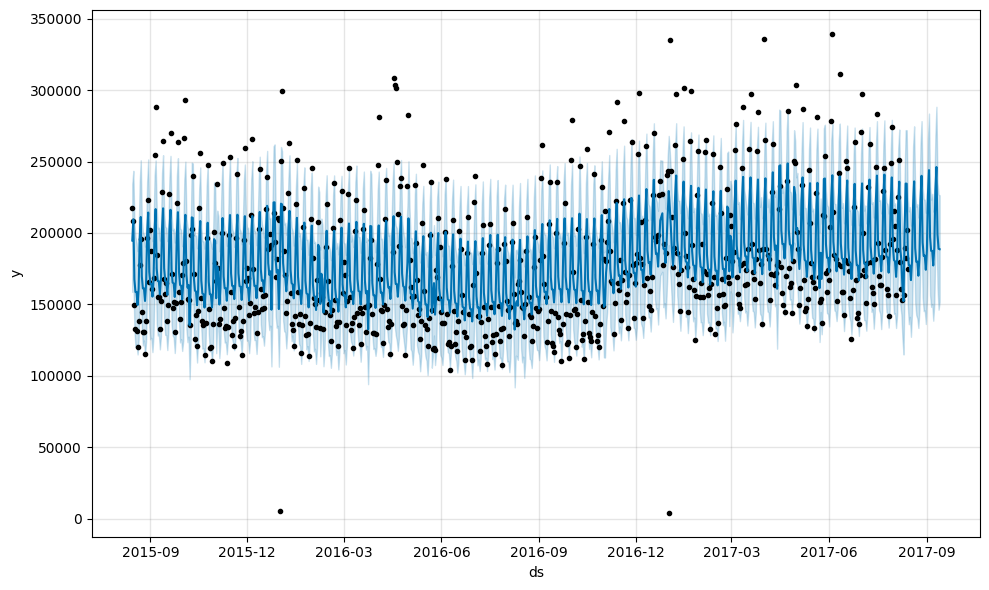

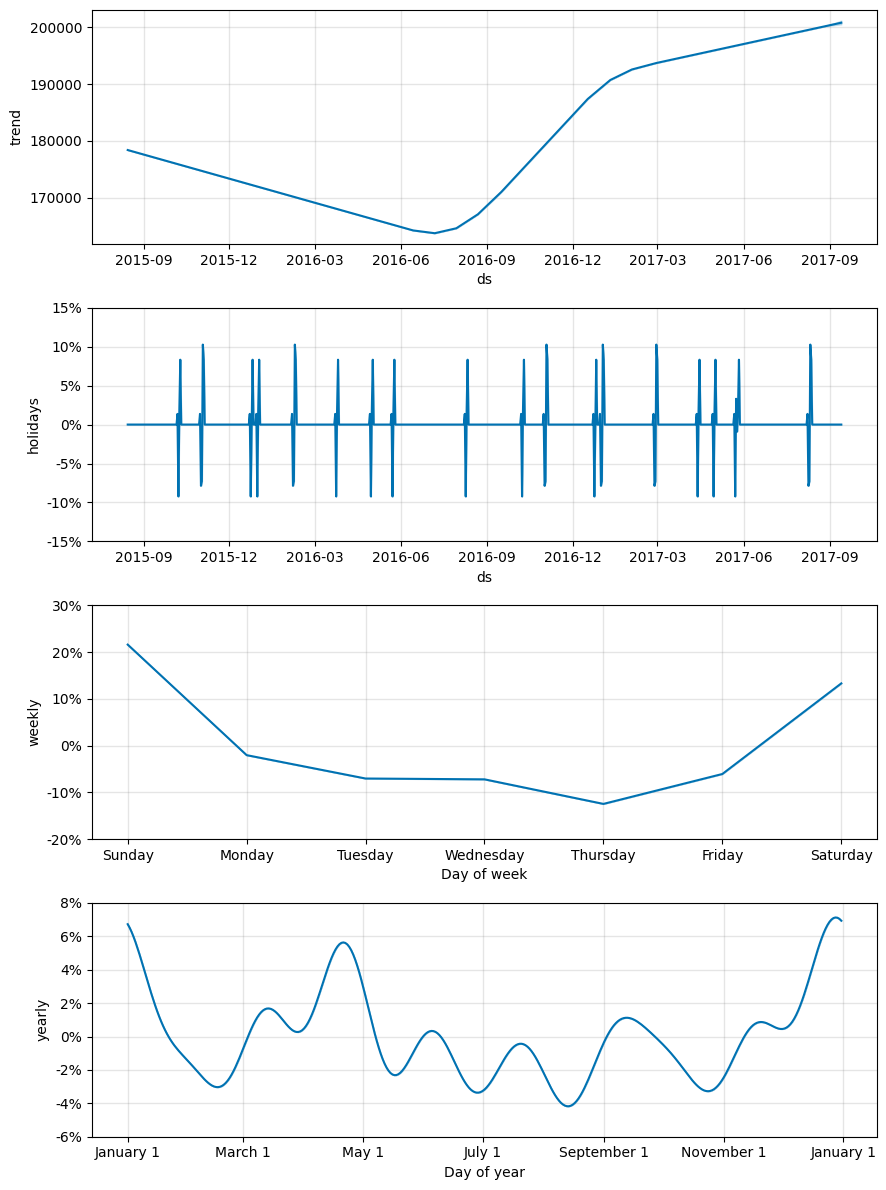

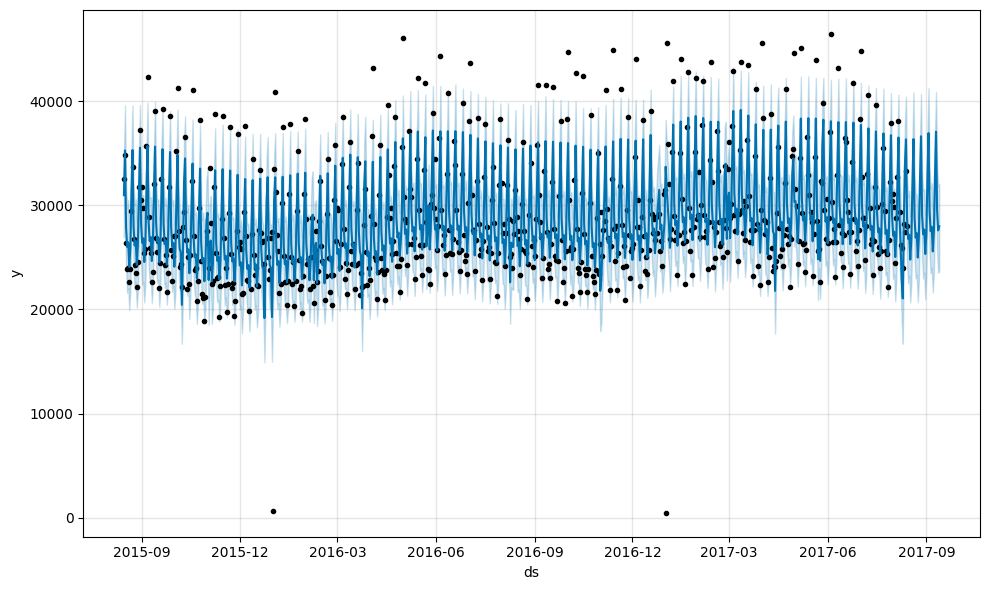

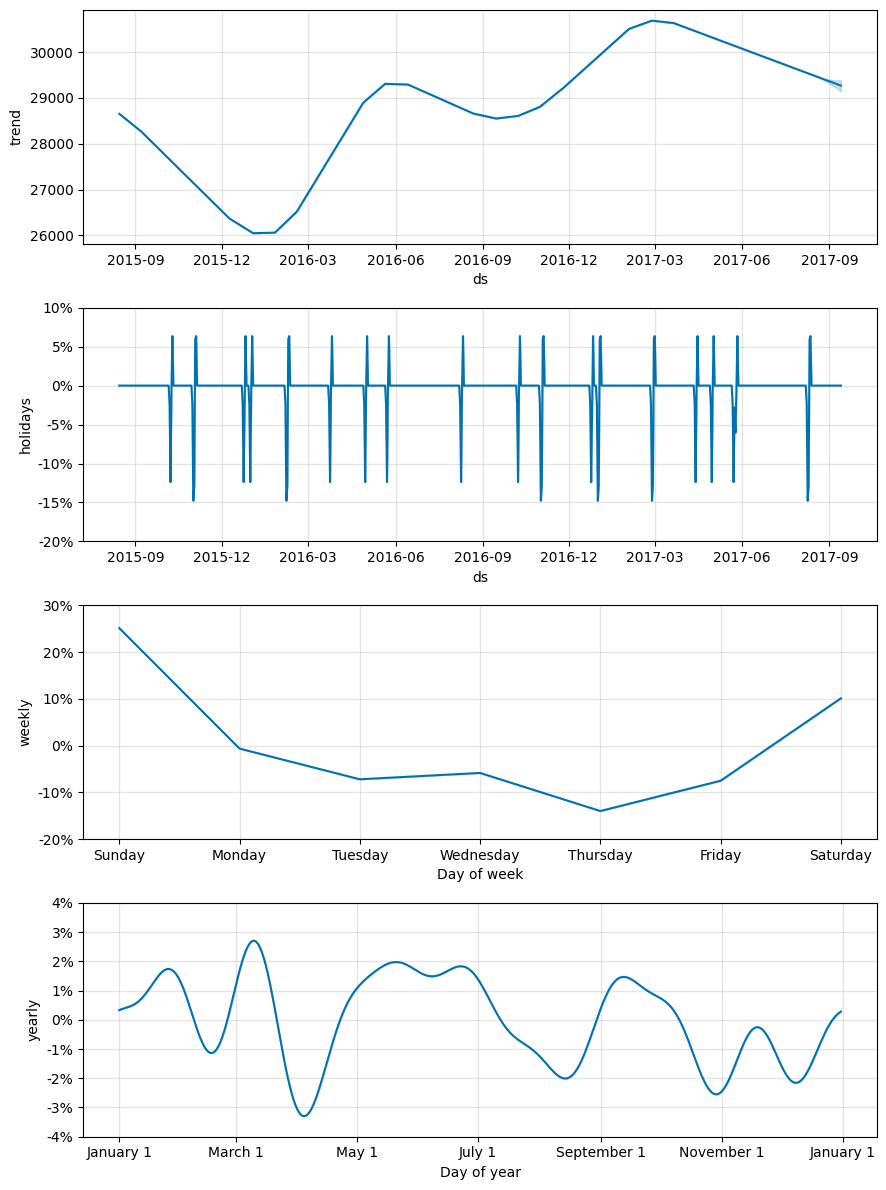

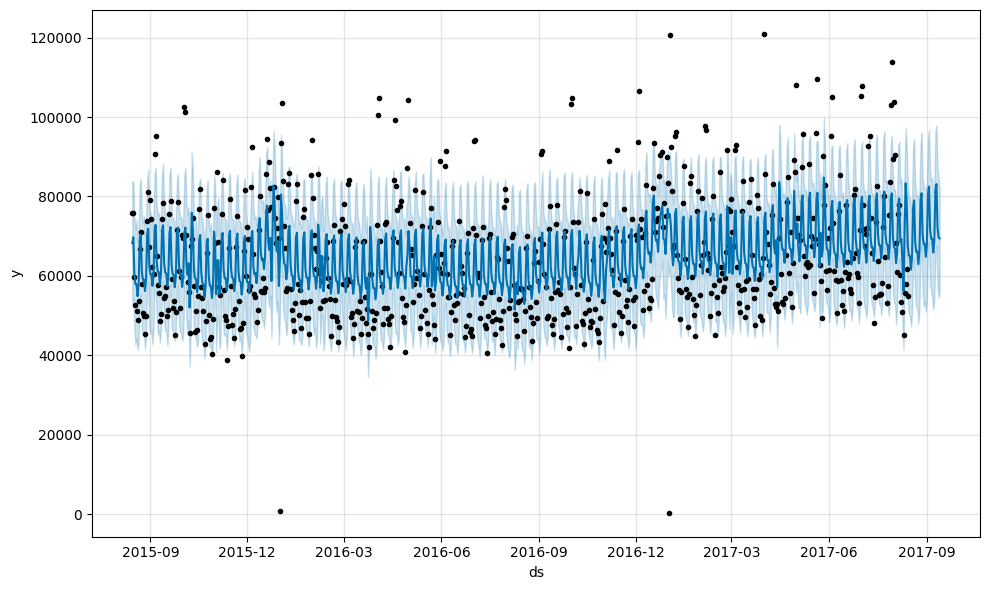

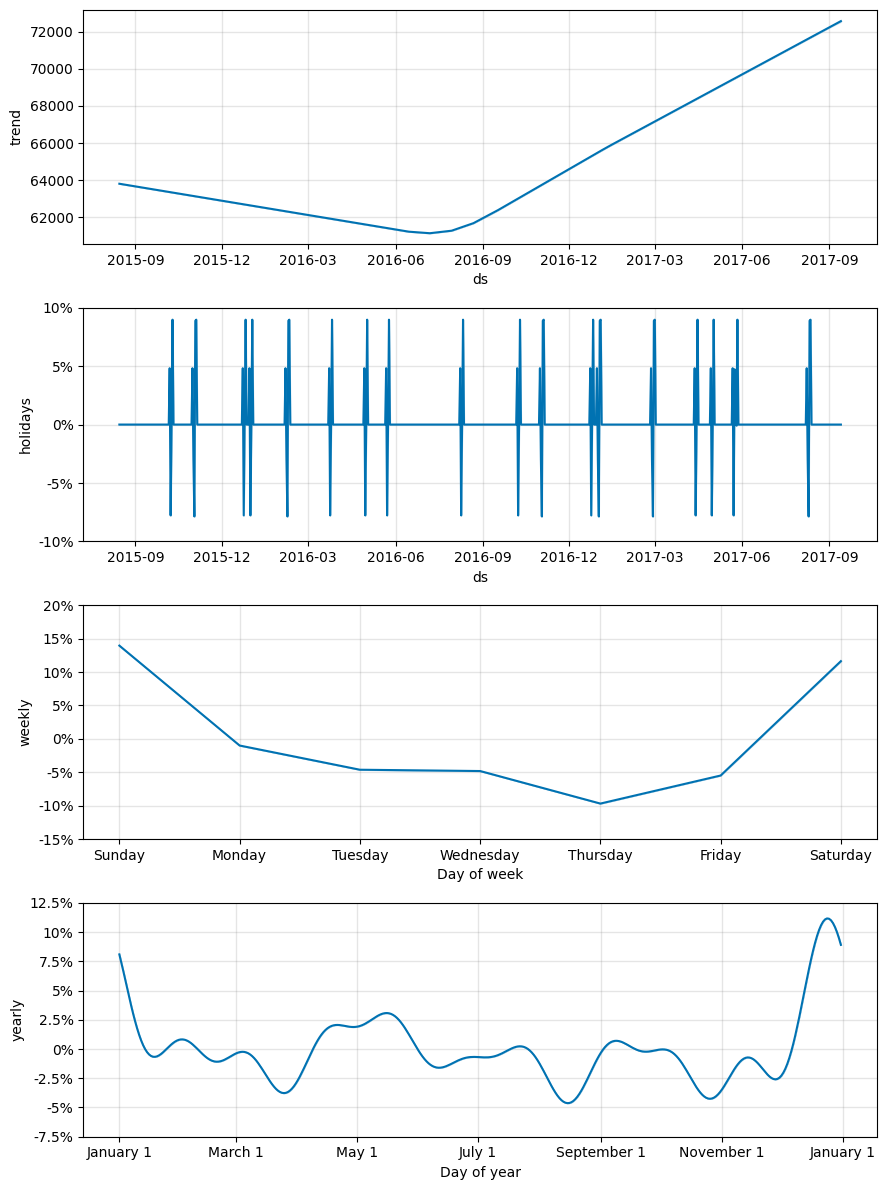

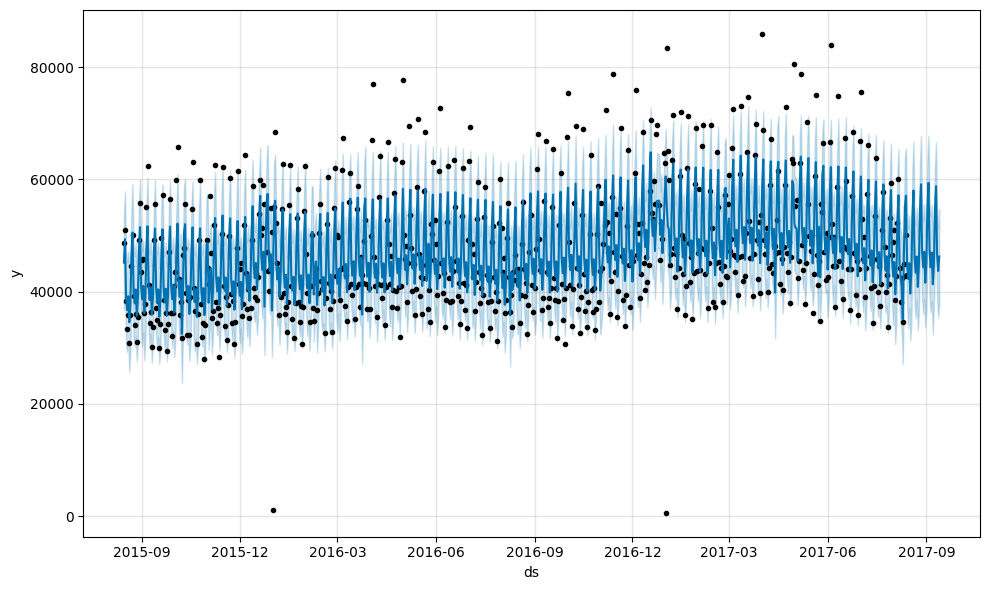

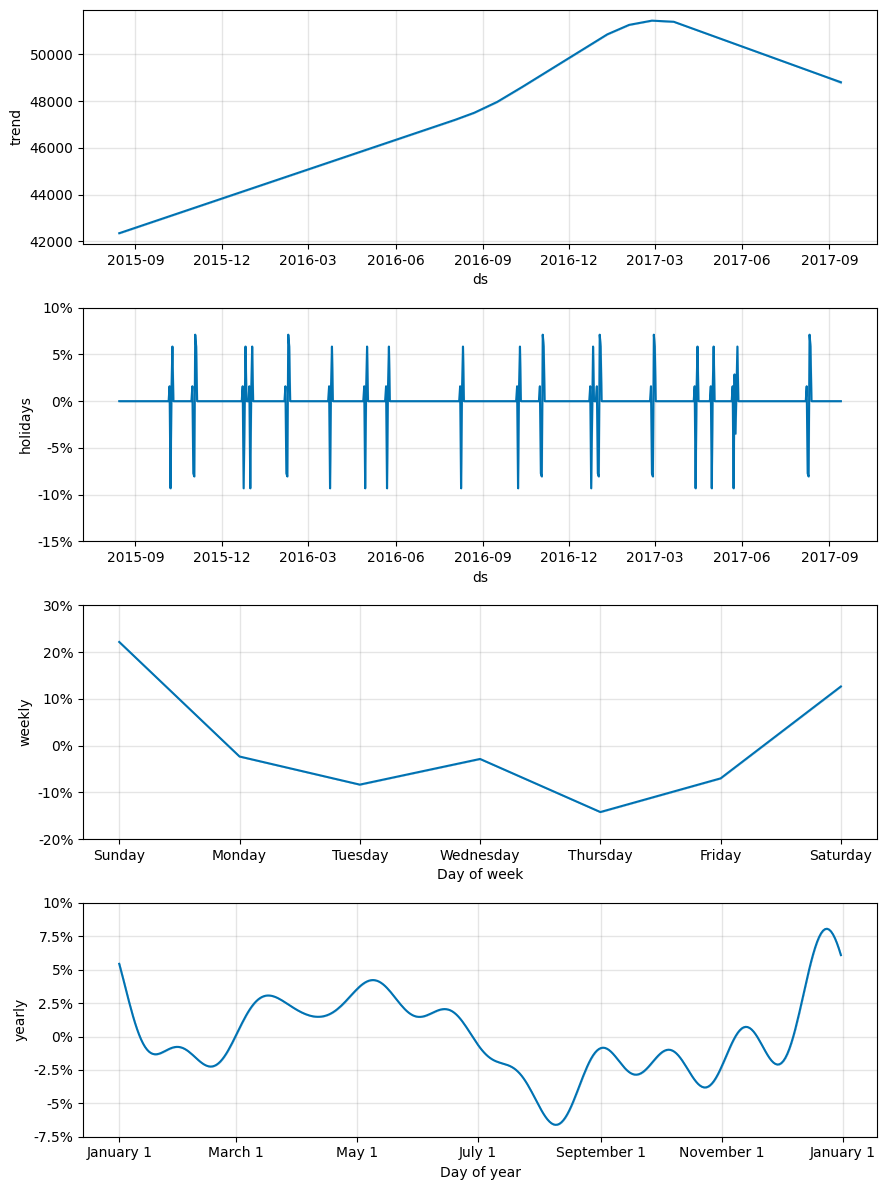

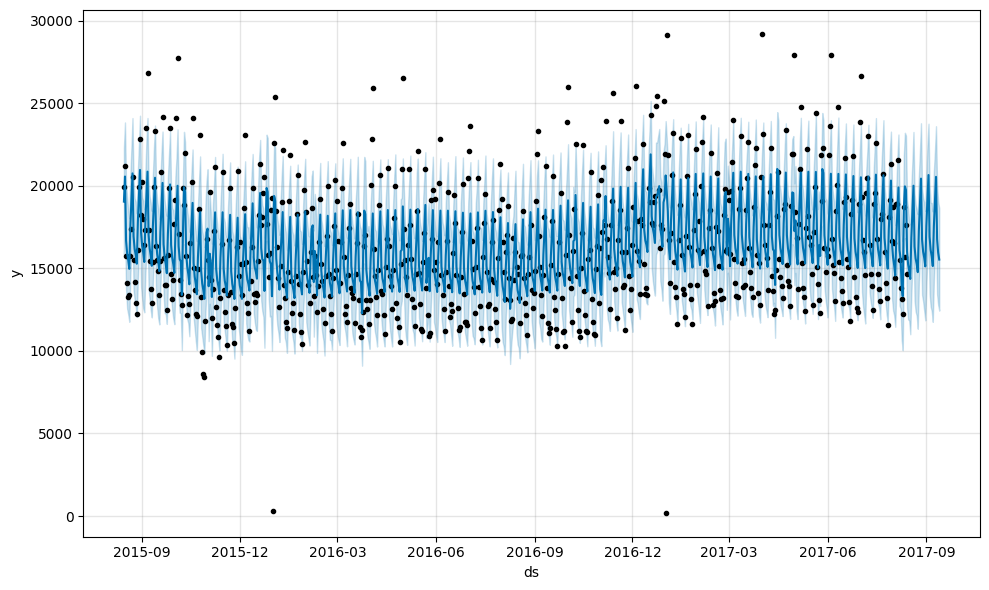

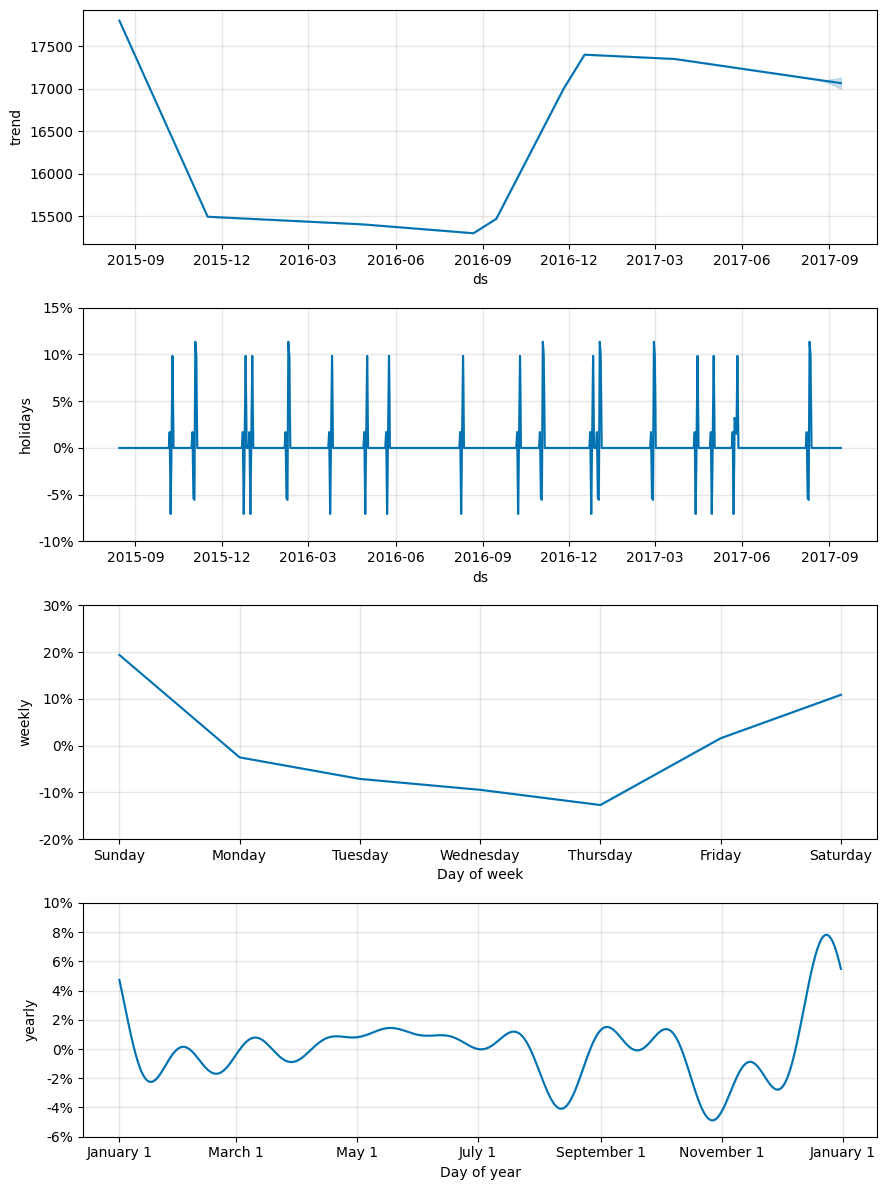

In [173]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [175]:
df_copy.head()

ds        y
0 2015-08-15 19946.92
1 2015-08-16 21178.46
2 2015-08-17 15755.02
3 2015-08-18 14119.25
4 2015-08-19 13250.04

#### Saving the model

In [176]:
from prophet.serialize import model_to_json, model_from_json

with open('sales_forecast.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('sales_forecast.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model